# Adaptive and Gradient Boosting

In this notebook, we demonstrate the use of AdaBoost and gradient boosting, incuding several state-of-the-art implementations of this very powerful and flexible algorithm that greatly speed up training. 

We use the stock return dataset with a few engineered factors created in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature_engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb).

## Update

This notebook now uses `sklearn.ensemble.HistGradientBoostingClassifier`.

## Imports and Settings

In [1]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [3]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [4]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

We use the `engineered_features` dataset created in [Chapter 4, Alpha Factor Research](../04_alpha_factor_research)

Set data store location:

In [5]:
DATA_STORE = '../data/assets.h5'

In [6]:
def get_data(start='2000', end='2019', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

Define columns with categorical data:

In [7]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

Integer-encode categorical columns:

In [8]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1).astype(int)
    return df

### One-Hot Encoding

Create dummy variables from categorical columns if needed:

In [9]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

Create holdout test set to estimate generalization error after cross-validation:

In [10]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

The algorithms in this chapter use a dataset generated in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) that needs to be executed first.

In [11]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [12]:
X_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 107403 entries, ('000020', Timestamp('2001-01-31 00:00:00')) to ('097950', Timestamp('2018-02-28 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      107403 non-null  float64
 1   return_2m      107403 non-null  float64
 2   return_3m      107403 non-null  float64
 3   return_6m      107403 non-null  float64
 4   return_9m      107403 non-null  float64
 5   return_12m     107403 non-null  float64
 6   Mkt-RF         107403 non-null  float64
 7   SMB            107403 non-null  float64
 8   HML            107403 non-null  float64
 9   RMW            107403 non-null  float64
 10  CMA            107403 non-null  float64
 11  momentum_2     107403 non-null  float64
 12  momentum_3     107403 non-null  float64
 13  momentum_6     107403 non-null  float64
 14  momentum_9     107403 non-null  float64
 15  momentum_12    107403 non-null  float6

In [13]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

Custom Time Series KFold generator.

In [14]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [15]:
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

In [16]:
run_time = {}

### CV Metrics

Define some metrics for use with cross-validation:

In [17]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

Helper function that runs cross-validation for the various algorithms.

In [18]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                            X=X, 
                            y=y,
                            scoring=list(metrics.keys()),
                            cv=cv,
                            return_train_score=True,
                            n_jobs=n_jobs,
                            verbose=1,
                            fit_params=fit_params)
    duration = time() - start
    return scores, duration

### CV Result Handler Functions

The following helper functions manipulate and plot the cross-validation results to produce the outputs below.

In [19]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [20]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

## Baseline Classifier

`sklearn` provides the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes predictions using simple rule and is useful as a simple baseline to compare with the other (real) classifiers we use below.

The `stratified` rule generates predictions based on the training set’s class distribution, i.e. always predicts the most frequent class.

In [21]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [22]:
algo = 'dummy_clf'

In [23]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    dummy_cv_result, run_time[algo] = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

Unsurprisingly, it produces results near the AUC threshold for arbitrary predictions of 0.5:

In [24]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.504968,0.499715
Accuracy,0.504968,0.499715
F1,0.523382,0.499855
Log Loss,-17.138543,-17.274679
Precision,0.577828,0.499858
Recall,0.503795,0.499853


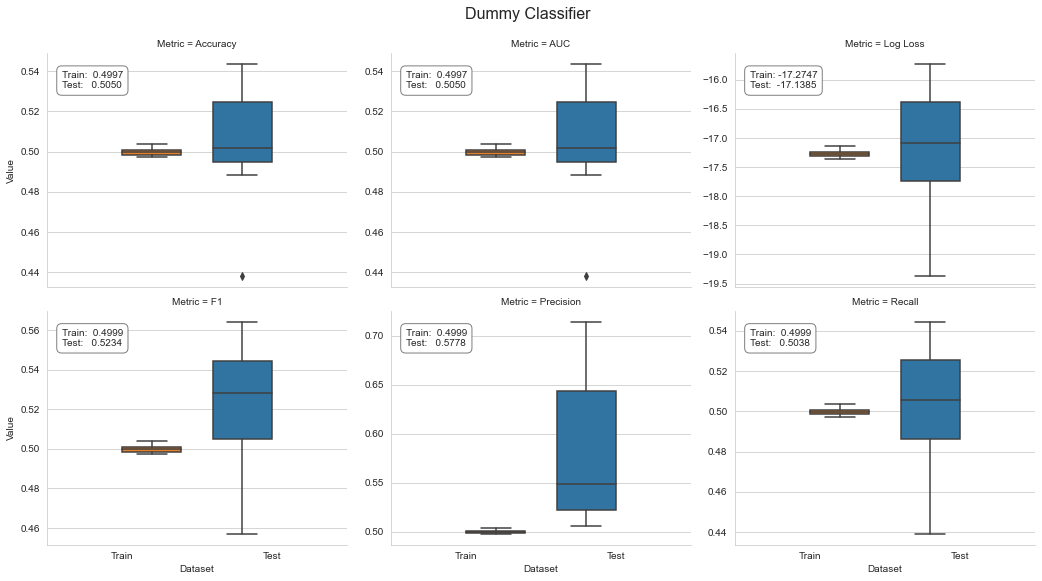

In [25]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

For comparison, we train a `RandomForestClassifier` as presented in [Chapter 11 on Decision Trees and Random Forests](../11_decision_trees_random_forests/02_random_forest.ipynb).

### Configure

In [26]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [27]:
algo = 'random_forest'

In [28]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    rf_cv_result, run_time[algo] = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

### Plot Results

In [29]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.515390,1.000000
Accuracy,0.500695,1.000000
F1,0.437020,1.000000
Log Loss,-0.723907,-0.181345
Precision,0.560962,1.000000
Recall,0.456740,1.000000


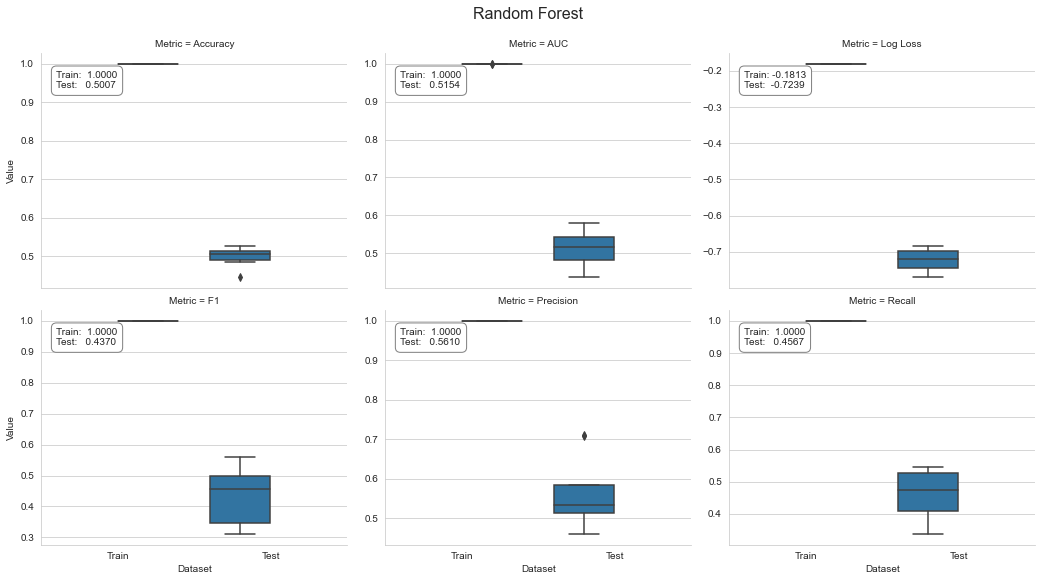

In [30]:
plot_result(rf_result, model='Random Forest')

## scikit-learn: AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. 

As demonstrated in the [previous chapter](../../10_decision_trees_random_forests), changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [31]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_impurity_split=None, 
                                        class_weight=None)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [32]:
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                             n_estimators=100,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a custom 12-fold rolling time-series split to predict 1 month ahead for the last 12 months in the sample, using all available prior data for training, as shown in the following code:

In [33]:
algo = 'adaboost'

In [34]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    ada_cv_result, run_time[algo] = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

### Plot Result

In [35]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.512397,0.604948
Accuracy,0.496719,0.575388
F1,0.376783,0.575210
Log Loss,-0.693310,-0.692814
Precision,0.537264,0.576022
Recall,0.459320,0.576085


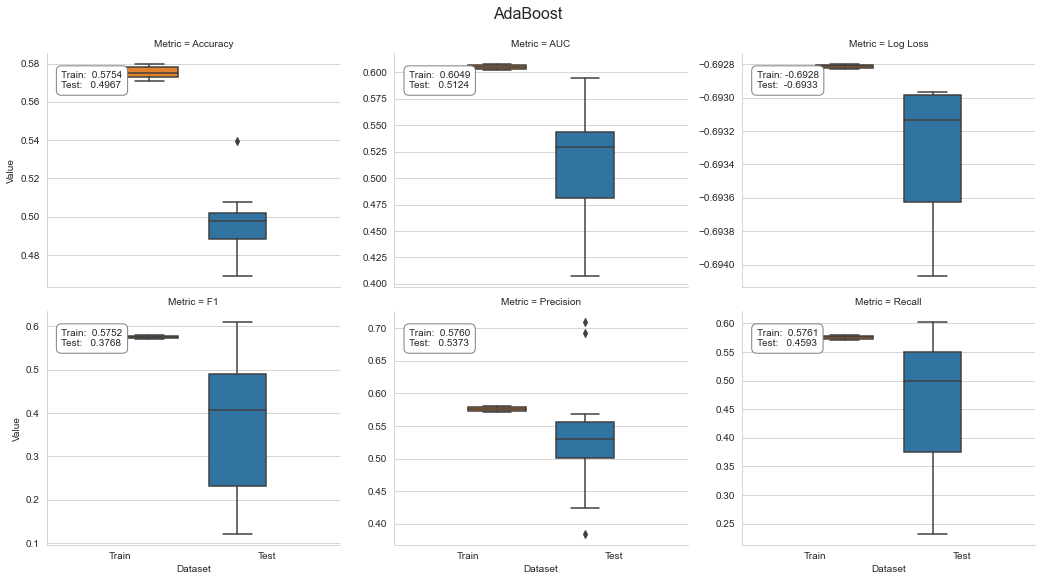

In [36]:
plot_result(ada_result, model='AdaBoost')

## scikit-learn: HistGradientBoostingClassifier

The ensemble module of sklearn contains an implementation of gradient boosting trees for regression and classification, both binary and multiclass. 

### Configure

The following [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) initialization code illustrates the key tuning parameters that we previously introduced, in addition to those that we are familiar with from looking at standalone decision tree models.

This estimator is much faster than [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) for big datasets (n_samples >= 10 000).

This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

In [37]:
gb_clf = HistGradientBoostingClassifier(loss='binary_crossentropy',              
                                        learning_rate=0.1,          # regulates the contribution of each tree
                                        max_iter=100,               # number of boosting stages
                                        min_samples_leaf=20,
                                        max_depth=None,
                                        random_state=None,
                                        max_leaf_nodes=31,           # opt value depends on feature interaction
                                        warm_start=False,
#                                         early_stopping=True,
#                                         scoring='loss',
#                                         validation_fraction=0.1,
#                                         n_iter_no_change=None,
                                        verbose=0,
                                        tol=0.0001)

### Cross-validate

In [38]:
algo = 'sklearn_gbm'

In [39]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    gb_cv_result, run_time[algo] = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

### Plot Results

In [40]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.518694,0.759658
Accuracy,0.499760,0.689959
F1,0.330737,0.690077
Log Loss,-0.726302,-0.602652
Precision,0.543314,0.690847
Recall,0.431390,0.690477


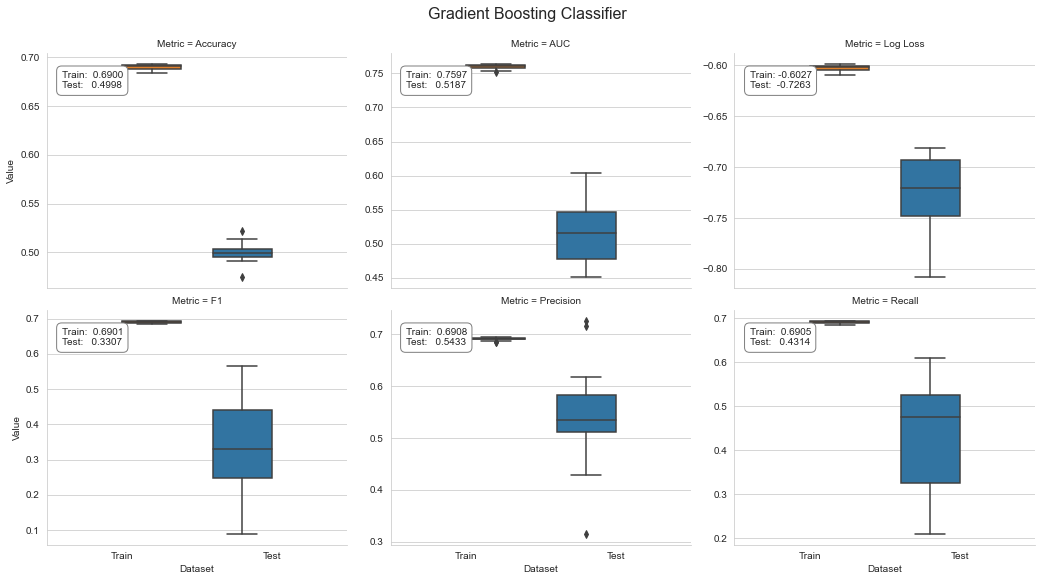

In [41]:
plot_result(gb_result, model='Gradient Boosting Classifier')

### Partial Dependence Plots

Drop time periods to avoid over-reliance for in-sample fit.

In [42]:
X_ = X_factors_clean.drop(['year', 'month'], axis=1)

In [43]:
fname = results_path / f'{algo}_model.joblib'
if not Path(fname).exists():
    gb_clf.fit(y=y_clean, X=X_)
    joblib.dump(gb_clf, fname)
else:
    gb_clf = joblib.load(fname)

In [44]:
# mean accuracy
gb_clf.score(X=X_, y=y_clean)

0.5984506509013601

In [45]:
y_score = gb_clf.predict_proba(X_)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.6453990795700404

#### One-way and two-way partial depende plots

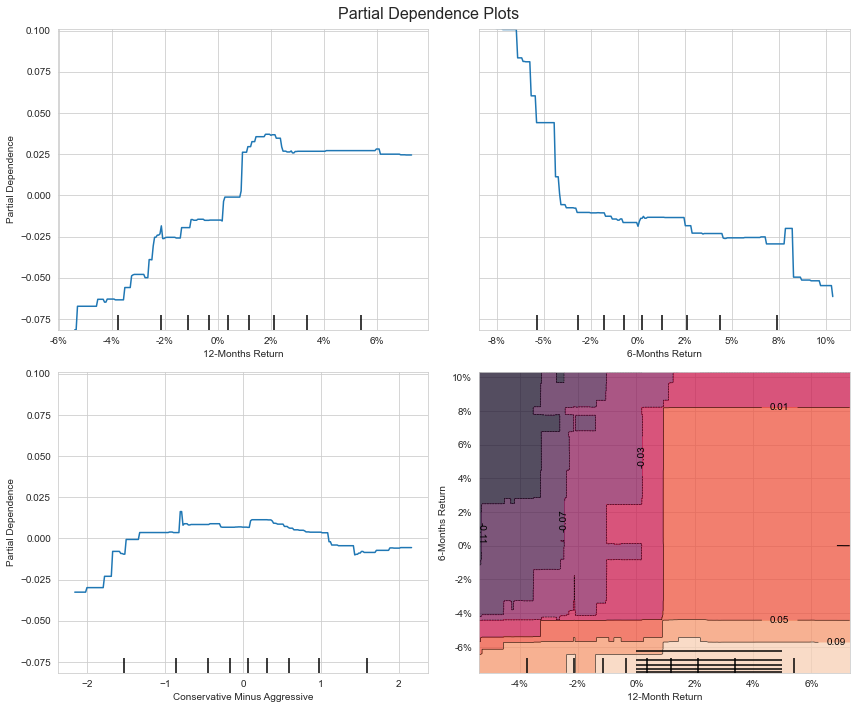

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

plot_partial_dependence(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    n_cols=2,
    response_method='decision_function',
    grid_resolution=250,
    ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95)


#### Two-way partial dependence as 3D plot

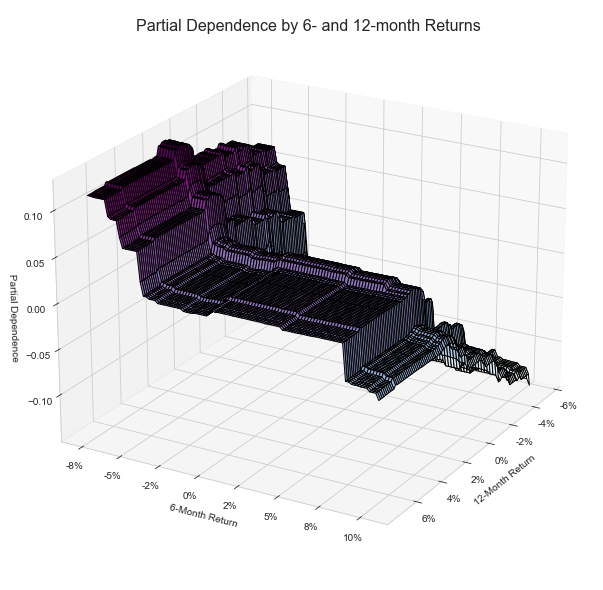

In [47]:
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf,
                               features=targets,
                               X=X_,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)
fig.tight_layout()


## XGBoost

See XGBoost [docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html) for details on parameters and usage.

### Configure

In [48]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [49]:
algo = 'xgboost'

In [50]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

### Plot Results

In [51]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.506702,0.673227
Accuracy,0.493143,0.619829
F1,0.324929,0.618680
Log Loss,-0.717270,-0.654348
Precision,0.532639,0.622753
Recall,0.436096,0.621120


FileNotFoundError: [Errno 2] No such file or directory: 'figures/xgboost_cv_result.png'

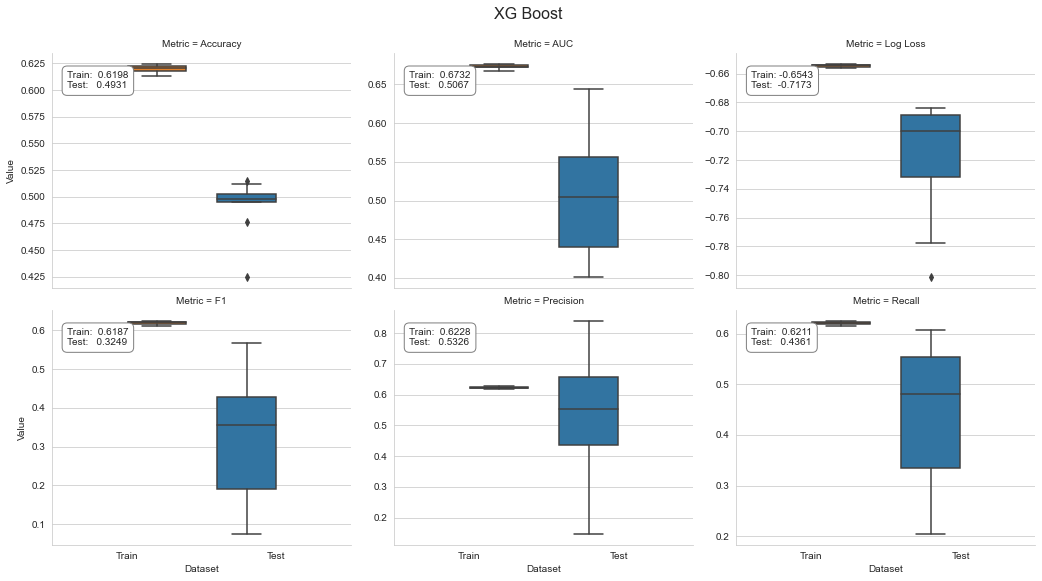

In [52]:
plot_result(xbg_result, model='XG Boost', fname=f'figures/{algo}_cv_result')

### Feature Importance

In [53]:
xgb_clf.fit(X=X_dummies, y=y)

[19:02:58] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:02:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [54]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X_dummies.columns)

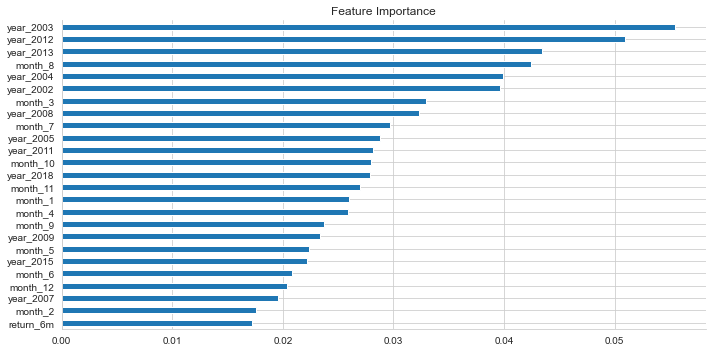

In [55]:
fi.nlargest(25).sort_values().plot.barh(figsize=(10, 5), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

## LightGBM

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for details on parameters and usage.

### Configure

In [56]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
#                          device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
                        )

### Cross-Validate

#### Using categorical features

In [57]:
algo = 'lgb_factors'

In [58]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result, run_time[algo] = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   44.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   44.9s finished


##### Plot Results

In [59]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.526646,0.789749
Accuracy,0.507874,0.714150
F1,0.447819,0.714355
Log Loss,-0.704354,-0.577382
Precision,0.563207,0.714649
Recall,0.493625,0.714537


FileNotFoundError: [Errno 2] No such file or directory: 'figures/lgb_factors_cv_result.png'

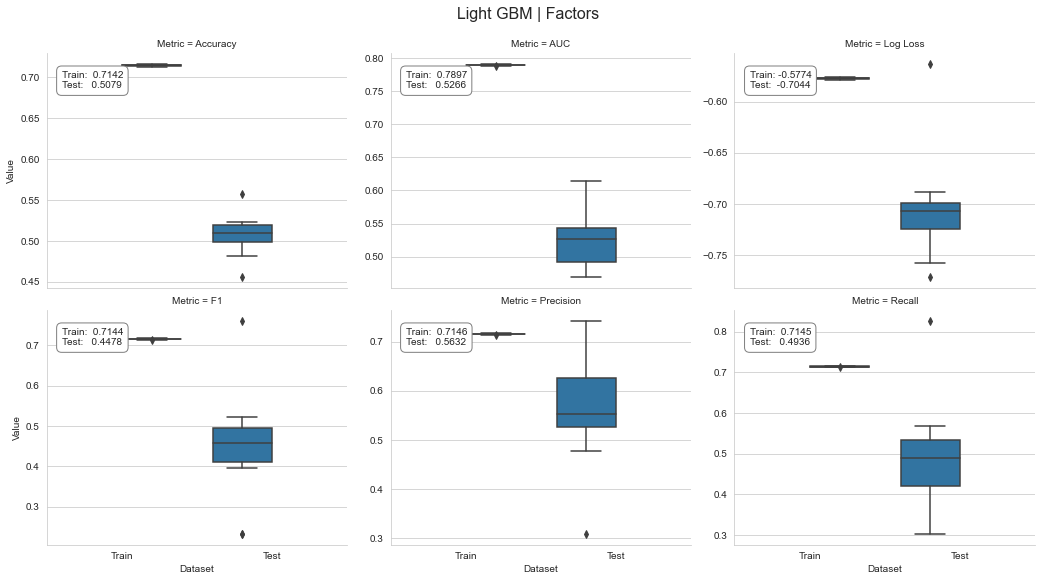

In [60]:
plot_result(lgb_factor_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

#### Using dummy variables

In [61]:
algo = 'lgb_dummies'

In [62]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result, run_time[algo] = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.9s finished


##### Plot results

In [63]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,NaN,NaN
Accuracy,NaN,NaN
F1,NaN,NaN
Log Loss,NaN,NaN
Precision,NaN,NaN
Recall,NaN,NaN


FileNotFoundError: [Errno 2] No such file or directory: 'figures/lgb_dummies_cv_result.png'

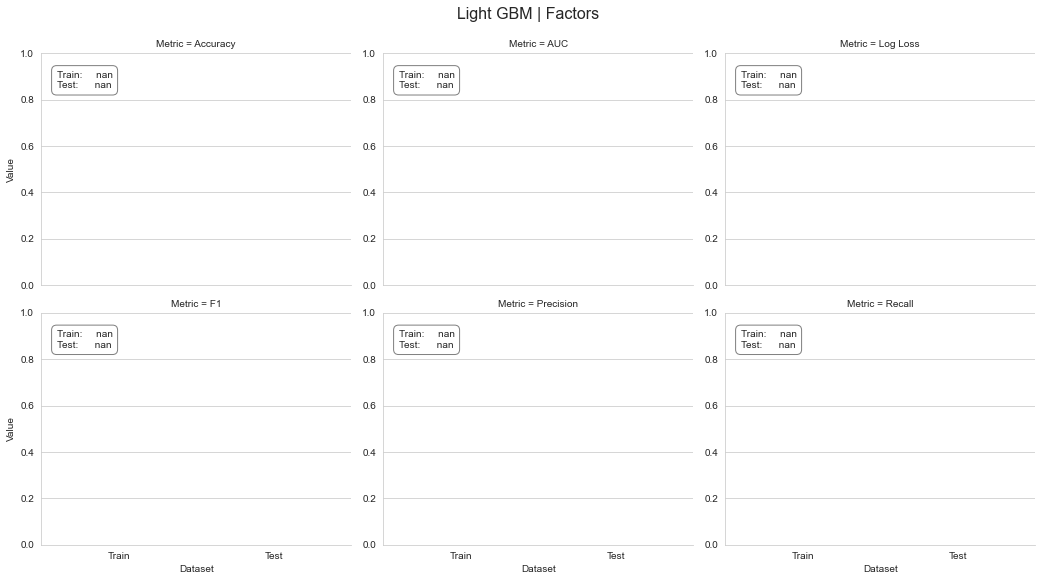

In [64]:
plot_result(lgb_dummy_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

## Catboost

See CatBoost [docs](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) for details on parameters and usage.

### CPU

#### Configure

In [65]:
cat_clf = CatBoostClassifier()

#### Cross-Validate

In [66]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

Catboost requires integer values for categorical variables.

In [67]:
algo = 'catboost'

In [68]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_cv_result, run_time[algo] = run_cv(cat_clf,
                                           X=X_factors,
                                           fit_params=fit_params,
                                           n_jobs=-1)
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 13.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 13.3min finished


#### Plot Results

In [69]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.514510,0.835487
Accuracy,0.501443,0.755244
F1,0.502954,0.755435
Log Loss,-0.697303,-0.513426
Precision,0.571752,0.755597
Recall,0.534912,0.755529


In [ ]:
plot_result(cat_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

### GPU

> Naturally, the following requires that you have a GPU.

#### Configure

In [70]:
cat_clf_gpu = CatBoostClassifier(task_type='GPU')

#### Cross-Validate

In [71]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [72]:
algo = 'catboost_gpu'

In [73]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_gpu_cv_result, run_time[algo] = run_cv(cat_clf_gpu,
                                               y=y,
                                               X=X_factors,
                                               fit_params=fit_params, 
                                               n_jobs=1)
    joblib.dump(cat_gpu_cv_result, fname)
else:
    cat_gpu_cv_result = joblib.load(fname)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.026073
0:	learn: 0.6896340	total: 36.9ms	remaining: 36.9s
1:	learn: 0.6862321	total: 57.7ms	remaining: 28.8s
2:	learn: 0.6830599	total: 77.8ms	remaining: 25.8s
3:	learn: 0.6800505	total: 100ms	remaining: 25s
4:	learn: 0.6771605	total: 124ms	remaining: 24.7s
5:	learn: 0.6744645	total: 152ms	remaining: 25.1s
6:	learn: 0.6718101	total: 174ms	remaining: 24.7s
7:	learn: 0.6692965	total: 195ms	remaining: 24.2s
8:	learn: 0.6669244	total: 216ms	remaining: 23.8s
9:	learn: 0.6646348	total: 238ms	remaining: 23.5s
10:	learn: 0.6625120	total: 259ms	remaining: 23.3s
11:	learn: 0.6603153	total: 280ms	remaining: 23.1s
12:	learn: 0.6582855	total: 301ms	remaining: 22.9s
13:	learn: 0.6563413	total: 321ms	remaining: 22.6s
14:	learn: 0.6545614	total: 341ms	remaining: 22.4s
15:	learn: 0.6527930	total: 361ms	remaining: 22.2s
16:	learn: 0.6510966	total: 380ms	remaining: 22s
17:	learn: 0.6494529	total: 403ms	remaining: 22s
18:	learn: 0.6478659	total: 428ms	remaining: 22.1s
19:	learn: 0.6

161:	learn: 0.6063042	total: 7.56s	remaining: 39.1s
162:	learn: 0.6062718	total: 7.58s	remaining: 38.9s
163:	learn: 0.6062489	total: 7.6s	remaining: 38.8s
164:	learn: 0.6061298	total: 7.62s	remaining: 38.6s
165:	learn: 0.6061032	total: 7.65s	remaining: 38.4s
166:	learn: 0.6060644	total: 7.67s	remaining: 38.3s
167:	learn: 0.6059282	total: 7.7s	remaining: 38.1s
168:	learn: 0.6059052	total: 7.73s	remaining: 38s
169:	learn: 0.6058737	total: 7.75s	remaining: 37.8s
170:	learn: 0.6058550	total: 7.77s	remaining: 37.7s
171:	learn: 0.6058310	total: 7.8s	remaining: 37.5s
172:	learn: 0.6057841	total: 7.83s	remaining: 37.4s
173:	learn: 0.6057240	total: 7.85s	remaining: 37.3s
174:	learn: 0.6056100	total: 7.87s	remaining: 37.1s
175:	learn: 0.6055888	total: 7.9s	remaining: 37s
176:	learn: 0.6055494	total: 7.92s	remaining: 36.8s
177:	learn: 0.6054388	total: 7.94s	remaining: 36.7s
178:	learn: 0.6054061	total: 7.96s	remaining: 36.5s
179:	learn: 0.6053678	total: 7.99s	remaining: 36.4s
180:	learn: 0.605335

324:	learn: 0.5997430	total: 11.4s	remaining: 23.6s
325:	learn: 0.5996761	total: 11.4s	remaining: 23.5s
326:	learn: 0.5996444	total: 11.4s	remaining: 23.5s
327:	learn: 0.5995669	total: 11.4s	remaining: 23.4s
328:	learn: 0.5995553	total: 11.4s	remaining: 23.3s
329:	learn: 0.5995452	total: 11.5s	remaining: 23.3s
330:	learn: 0.5995392	total: 11.5s	remaining: 23.2s
331:	learn: 0.5994723	total: 11.5s	remaining: 23.1s
332:	learn: 0.5994631	total: 11.5s	remaining: 23.1s
333:	learn: 0.5993836	total: 11.5s	remaining: 23s
334:	learn: 0.5993100	total: 11.6s	remaining: 23s
335:	learn: 0.5992665	total: 11.6s	remaining: 22.9s
336:	learn: 0.5992415	total: 11.6s	remaining: 22.8s
337:	learn: 0.5991852	total: 11.6s	remaining: 22.8s
338:	learn: 0.5991732	total: 11.6s	remaining: 22.7s
339:	learn: 0.5991501	total: 11.7s	remaining: 22.6s
340:	learn: 0.5991106	total: 11.7s	remaining: 22.6s
341:	learn: 0.5990594	total: 11.7s	remaining: 22.5s
342:	learn: 0.5990465	total: 11.7s	remaining: 22.5s
343:	learn: 0.59

488:	learn: 0.5947471	total: 14.8s	remaining: 15.5s
489:	learn: 0.5947321	total: 14.9s	remaining: 15.5s
490:	learn: 0.5947242	total: 14.9s	remaining: 15.4s
491:	learn: 0.5947094	total: 14.9s	remaining: 15.4s
492:	learn: 0.5946585	total: 14.9s	remaining: 15.4s
493:	learn: 0.5946525	total: 15s	remaining: 15.3s
494:	learn: 0.5946488	total: 15s	remaining: 15.3s
495:	learn: 0.5946361	total: 15s	remaining: 15.2s
496:	learn: 0.5946012	total: 15s	remaining: 15.2s
497:	learn: 0.5945878	total: 15s	remaining: 15.2s
498:	learn: 0.5945725	total: 15.1s	remaining: 15.1s
499:	learn: 0.5945584	total: 15.1s	remaining: 15.1s
500:	learn: 0.5945069	total: 15.1s	remaining: 15s
501:	learn: 0.5944466	total: 15.1s	remaining: 15s
502:	learn: 0.5944361	total: 15.1s	remaining: 15s
503:	learn: 0.5944273	total: 15.2s	remaining: 14.9s
504:	learn: 0.5943804	total: 15.2s	remaining: 14.9s
505:	learn: 0.5943124	total: 15.2s	remaining: 14.8s
506:	learn: 0.5942902	total: 15.2s	remaining: 14.8s
507:	learn: 0.5942417	total:

655:	learn: 0.5906249	total: 18.4s	remaining: 9.66s
656:	learn: 0.5905859	total: 18.4s	remaining: 9.63s
657:	learn: 0.5905728	total: 18.5s	remaining: 9.6s
658:	learn: 0.5905569	total: 18.5s	remaining: 9.57s
659:	learn: 0.5905309	total: 18.5s	remaining: 9.53s
660:	learn: 0.5905061	total: 18.5s	remaining: 9.5s
661:	learn: 0.5904479	total: 18.5s	remaining: 9.47s
662:	learn: 0.5904341	total: 18.6s	remaining: 9.44s
663:	learn: 0.5904246	total: 18.6s	remaining: 9.41s
664:	learn: 0.5904082	total: 18.6s	remaining: 9.38s
665:	learn: 0.5903854	total: 18.6s	remaining: 9.34s
666:	learn: 0.5903781	total: 18.7s	remaining: 9.31s
667:	learn: 0.5903588	total: 18.7s	remaining: 9.28s
668:	learn: 0.5903371	total: 18.7s	remaining: 9.25s
669:	learn: 0.5902924	total: 18.7s	remaining: 9.22s
670:	learn: 0.5902825	total: 18.7s	remaining: 9.19s
671:	learn: 0.5902678	total: 18.8s	remaining: 9.16s
672:	learn: 0.5902285	total: 18.8s	remaining: 9.13s
673:	learn: 0.5902143	total: 18.8s	remaining: 9.1s
674:	learn: 0.5

823:	learn: 0.5872549	total: 22.1s	remaining: 4.71s
824:	learn: 0.5872368	total: 22.1s	remaining: 4.68s
825:	learn: 0.5872097	total: 22.1s	remaining: 4.66s
826:	learn: 0.5872011	total: 22.1s	remaining: 4.63s
827:	learn: 0.5871888	total: 22.1s	remaining: 4.6s
828:	learn: 0.5871729	total: 22.2s	remaining: 4.57s
829:	learn: 0.5871568	total: 22.2s	remaining: 4.54s
830:	learn: 0.5871302	total: 22.2s	remaining: 4.52s
831:	learn: 0.5870815	total: 22.2s	remaining: 4.49s
832:	learn: 0.5870585	total: 22.3s	remaining: 4.46s
833:	learn: 0.5870528	total: 22.3s	remaining: 4.43s
834:	learn: 0.5870407	total: 22.3s	remaining: 4.41s
835:	learn: 0.5870274	total: 22.3s	remaining: 4.38s
836:	learn: 0.5870196	total: 22.3s	remaining: 4.35s
837:	learn: 0.5870050	total: 22.4s	remaining: 4.32s
838:	learn: 0.5869717	total: 22.4s	remaining: 4.29s
839:	learn: 0.5869264	total: 22.4s	remaining: 4.27s
840:	learn: 0.5869178	total: 22.4s	remaining: 4.24s
841:	learn: 0.5869068	total: 22.4s	remaining: 4.21s
842:	learn: 0

982:	learn: 0.5846862	total: 25.4s	remaining: 439ms
983:	learn: 0.5846804	total: 25.4s	remaining: 413ms
984:	learn: 0.5846617	total: 25.4s	remaining: 387ms
985:	learn: 0.5846414	total: 25.5s	remaining: 362ms
986:	learn: 0.5845843	total: 25.5s	remaining: 336ms
987:	learn: 0.5845675	total: 25.5s	remaining: 310ms
988:	learn: 0.5845528	total: 25.5s	remaining: 284ms
989:	learn: 0.5845414	total: 25.5s	remaining: 258ms
990:	learn: 0.5845319	total: 25.6s	remaining: 232ms
991:	learn: 0.5845153	total: 25.6s	remaining: 206ms
992:	learn: 0.5845095	total: 25.6s	remaining: 181ms
993:	learn: 0.5844784	total: 25.6s	remaining: 155ms
994:	learn: 0.5844594	total: 25.6s	remaining: 129ms
995:	learn: 0.5844552	total: 25.7s	remaining: 103ms
996:	learn: 0.5844383	total: 25.7s	remaining: 77.3ms
997:	learn: 0.5844269	total: 25.7s	remaining: 51.5ms
998:	learn: 0.5844181	total: 25.7s	remaining: 25.8ms
999:	learn: 0.5844102	total: 25.8s	remaining: 0us
Learning rate set to 0.02608
0:	learn: 0.6897136	total: 20.9ms	

148:	learn: 0.6077623	total: 3.12s	remaining: 17.8s
149:	learn: 0.6077334	total: 3.14s	remaining: 17.8s
150:	learn: 0.6076093	total: 3.17s	remaining: 17.8s
151:	learn: 0.6075816	total: 3.19s	remaining: 17.8s
152:	learn: 0.6075480	total: 3.21s	remaining: 17.8s
153:	learn: 0.6075278	total: 3.23s	remaining: 17.7s
154:	learn: 0.6074927	total: 3.25s	remaining: 17.7s
155:	learn: 0.6074673	total: 3.27s	remaining: 17.7s
156:	learn: 0.6074392	total: 3.29s	remaining: 17.7s
157:	learn: 0.6074210	total: 3.31s	remaining: 17.6s
158:	learn: 0.6074045	total: 3.33s	remaining: 17.6s
159:	learn: 0.6073758	total: 3.35s	remaining: 17.6s
160:	learn: 0.6073492	total: 3.37s	remaining: 17.6s
161:	learn: 0.6071853	total: 3.39s	remaining: 17.5s
162:	learn: 0.6071586	total: 3.41s	remaining: 17.5s
163:	learn: 0.6070405	total: 3.43s	remaining: 17.5s
164:	learn: 0.6070228	total: 3.45s	remaining: 17.5s
165:	learn: 0.6069109	total: 3.48s	remaining: 17.5s
166:	learn: 0.6067931	total: 3.5s	remaining: 17.4s
167:	learn: 0

314:	learn: 0.6002434	total: 6.63s	remaining: 14.4s
315:	learn: 0.6001882	total: 6.65s	remaining: 14.4s
316:	learn: 0.6001336	total: 6.67s	remaining: 14.4s
317:	learn: 0.6001238	total: 6.69s	remaining: 14.3s
318:	learn: 0.6001106	total: 6.71s	remaining: 14.3s
319:	learn: 0.6000355	total: 6.73s	remaining: 14.3s
320:	learn: 0.5999597	total: 6.75s	remaining: 14.3s
321:	learn: 0.5999375	total: 6.77s	remaining: 14.3s
322:	learn: 0.5999025	total: 6.79s	remaining: 14.2s
323:	learn: 0.5998280	total: 6.81s	remaining: 14.2s
324:	learn: 0.5998115	total: 6.84s	remaining: 14.2s
325:	learn: 0.5997861	total: 6.86s	remaining: 14.2s
326:	learn: 0.5997700	total: 6.88s	remaining: 14.2s
327:	learn: 0.5997608	total: 6.9s	remaining: 14.1s
328:	learn: 0.5997453	total: 6.92s	remaining: 14.1s
329:	learn: 0.5997290	total: 6.95s	remaining: 14.1s
330:	learn: 0.5997146	total: 6.97s	remaining: 14.1s
331:	learn: 0.5997012	total: 6.99s	remaining: 14.1s
332:	learn: 0.5996918	total: 7.01s	remaining: 14s
333:	learn: 0.5

476:	learn: 0.5956994	total: 10.1s	remaining: 11s
477:	learn: 0.5956858	total: 10.1s	remaining: 11s
478:	learn: 0.5956745	total: 10.1s	remaining: 11s
479:	learn: 0.5956640	total: 10.1s	remaining: 11s
480:	learn: 0.5956445	total: 10.2s	remaining: 11s
481:	learn: 0.5955429	total: 10.2s	remaining: 10.9s
482:	learn: 0.5955353	total: 10.2s	remaining: 10.9s
483:	learn: 0.5955225	total: 10.2s	remaining: 10.9s
484:	learn: 0.5954824	total: 10.2s	remaining: 10.9s
485:	learn: 0.5954708	total: 10.3s	remaining: 10.8s
486:	learn: 0.5954639	total: 10.3s	remaining: 10.8s
487:	learn: 0.5954490	total: 10.3s	remaining: 10.8s
488:	learn: 0.5953908	total: 10.3s	remaining: 10.8s
489:	learn: 0.5953754	total: 10.4s	remaining: 10.8s
490:	learn: 0.5953607	total: 10.4s	remaining: 10.8s
491:	learn: 0.5953404	total: 10.4s	remaining: 10.8s
492:	learn: 0.5953232	total: 10.4s	remaining: 10.7s
493:	learn: 0.5953095	total: 10.5s	remaining: 10.7s
494:	learn: 0.5952947	total: 10.5s	remaining: 10.7s
495:	learn: 0.5952766	

642:	learn: 0.5919103	total: 13.6s	remaining: 7.55s
643:	learn: 0.5918528	total: 13.6s	remaining: 7.53s
644:	learn: 0.5918172	total: 13.6s	remaining: 7.51s
645:	learn: 0.5918046	total: 13.7s	remaining: 7.49s
646:	learn: 0.5917851	total: 13.7s	remaining: 7.47s
647:	learn: 0.5917582	total: 13.7s	remaining: 7.45s
648:	learn: 0.5917483	total: 13.7s	remaining: 7.43s
649:	learn: 0.5917282	total: 13.8s	remaining: 7.41s
650:	learn: 0.5917179	total: 13.8s	remaining: 7.38s
651:	learn: 0.5917047	total: 13.8s	remaining: 7.36s
652:	learn: 0.5917006	total: 13.8s	remaining: 7.34s
653:	learn: 0.5916760	total: 13.8s	remaining: 7.32s
654:	learn: 0.5916634	total: 13.9s	remaining: 7.3s
655:	learn: 0.5916588	total: 13.9s	remaining: 7.27s
656:	learn: 0.5916455	total: 13.9s	remaining: 7.25s
657:	learn: 0.5916300	total: 13.9s	remaining: 7.23s
658:	learn: 0.5916176	total: 13.9s	remaining: 7.21s
659:	learn: 0.5915745	total: 14s	remaining: 7.19s
660:	learn: 0.5915691	total: 14s	remaining: 7.17s
661:	learn: 0.591

810:	learn: 0.5883892	total: 17.1s	remaining: 3.99s
811:	learn: 0.5883769	total: 17.1s	remaining: 3.97s
812:	learn: 0.5883621	total: 17.2s	remaining: 3.95s
813:	learn: 0.5883500	total: 17.2s	remaining: 3.93s
814:	learn: 0.5883455	total: 17.2s	remaining: 3.91s
815:	learn: 0.5883399	total: 17.2s	remaining: 3.88s
816:	learn: 0.5883269	total: 17.2s	remaining: 3.86s
817:	learn: 0.5883218	total: 17.3s	remaining: 3.84s
818:	learn: 0.5882735	total: 17.3s	remaining: 3.82s
819:	learn: 0.5882334	total: 17.3s	remaining: 3.8s
820:	learn: 0.5881827	total: 17.3s	remaining: 3.78s
821:	learn: 0.5881518	total: 17.3s	remaining: 3.76s
822:	learn: 0.5881444	total: 17.4s	remaining: 3.73s
823:	learn: 0.5881113	total: 17.4s	remaining: 3.71s
824:	learn: 0.5881080	total: 17.4s	remaining: 3.69s
825:	learn: 0.5881049	total: 17.4s	remaining: 3.67s
826:	learn: 0.5880840	total: 17.5s	remaining: 3.65s
827:	learn: 0.5880711	total: 17.5s	remaining: 3.63s
828:	learn: 0.5880513	total: 17.5s	remaining: 3.61s
829:	learn: 0

974:	learn: 0.5857508	total: 20.6s	remaining: 528ms
975:	learn: 0.5857421	total: 20.6s	remaining: 507ms
976:	learn: 0.5857350	total: 20.6s	remaining: 486ms
977:	learn: 0.5857015	total: 20.7s	remaining: 465ms
978:	learn: 0.5856526	total: 20.7s	remaining: 444ms
979:	learn: 0.5856503	total: 20.7s	remaining: 423ms
980:	learn: 0.5856032	total: 20.7s	remaining: 401ms
981:	learn: 0.5855929	total: 20.7s	remaining: 380ms
982:	learn: 0.5855843	total: 20.8s	remaining: 359ms
983:	learn: 0.5855747	total: 20.8s	remaining: 338ms
984:	learn: 0.5855378	total: 20.8s	remaining: 317ms
985:	learn: 0.5855331	total: 20.8s	remaining: 296ms
986:	learn: 0.5854850	total: 20.8s	remaining: 275ms
987:	learn: 0.5854485	total: 20.9s	remaining: 253ms
988:	learn: 0.5854370	total: 20.9s	remaining: 232ms
989:	learn: 0.5854252	total: 20.9s	remaining: 211ms
990:	learn: 0.5854230	total: 20.9s	remaining: 190ms
991:	learn: 0.5854035	total: 21s	remaining: 169ms
992:	learn: 0.5853906	total: 21s	remaining: 148ms
993:	learn: 0.58

138:	learn: 0.6088132	total: 2.99s	remaining: 18.5s
139:	learn: 0.6087829	total: 3.01s	remaining: 18.5s
140:	learn: 0.6086896	total: 3.03s	remaining: 18.5s
141:	learn: 0.6086660	total: 3.05s	remaining: 18.5s
142:	learn: 0.6086341	total: 3.08s	remaining: 18.4s
143:	learn: 0.6086013	total: 3.1s	remaining: 18.4s
144:	learn: 0.6085673	total: 3.12s	remaining: 18.4s
145:	learn: 0.6084318	total: 3.14s	remaining: 18.4s
146:	learn: 0.6084000	total: 3.17s	remaining: 18.4s
147:	learn: 0.6083768	total: 3.19s	remaining: 18.3s
148:	learn: 0.6082904	total: 3.21s	remaining: 18.3s
149:	learn: 0.6082635	total: 3.23s	remaining: 18.3s
150:	learn: 0.6081253	total: 3.25s	remaining: 18.3s
151:	learn: 0.6080771	total: 3.27s	remaining: 18.3s
152:	learn: 0.6080432	total: 3.3s	remaining: 18.3s
153:	learn: 0.6080162	total: 3.32s	remaining: 18.2s
154:	learn: 0.6079952	total: 3.34s	remaining: 18.2s
155:	learn: 0.6079733	total: 3.36s	remaining: 18.2s
156:	learn: 0.6079519	total: 3.38s	remaining: 18.2s
157:	learn: 0.

304:	learn: 0.6011753	total: 6.55s	remaining: 14.9s
305:	learn: 0.6011265	total: 6.57s	remaining: 14.9s
306:	learn: 0.6011100	total: 6.59s	remaining: 14.9s
307:	learn: 0.6010977	total: 6.62s	remaining: 14.9s
308:	learn: 0.6010900	total: 6.64s	remaining: 14.8s
309:	learn: 0.6010233	total: 6.66s	remaining: 14.8s
310:	learn: 0.6009763	total: 6.68s	remaining: 14.8s
311:	learn: 0.6009618	total: 6.7s	remaining: 14.8s
312:	learn: 0.6009480	total: 6.72s	remaining: 14.8s
313:	learn: 0.6009358	total: 6.74s	remaining: 14.7s
314:	learn: 0.6009278	total: 6.76s	remaining: 14.7s
315:	learn: 0.6008528	total: 6.79s	remaining: 14.7s
316:	learn: 0.6008409	total: 6.81s	remaining: 14.7s
317:	learn: 0.6008107	total: 6.83s	remaining: 14.6s
318:	learn: 0.6007933	total: 6.85s	remaining: 14.6s
319:	learn: 0.6007873	total: 6.87s	remaining: 14.6s
320:	learn: 0.6007635	total: 6.89s	remaining: 14.6s
321:	learn: 0.6007571	total: 6.92s	remaining: 14.6s
322:	learn: 0.6007474	total: 6.93s	remaining: 14.5s
323:	learn: 0

472:	learn: 0.5959986	total: 10.2s	remaining: 11.3s
473:	learn: 0.5959823	total: 10.2s	remaining: 11.3s
474:	learn: 0.5959721	total: 10.2s	remaining: 11.3s
475:	learn: 0.5959543	total: 10.2s	remaining: 11.3s
476:	learn: 0.5959465	total: 10.2s	remaining: 11.2s
477:	learn: 0.5959001	total: 10.3s	remaining: 11.2s
478:	learn: 0.5957830	total: 10.3s	remaining: 11.2s
479:	learn: 0.5957312	total: 10.3s	remaining: 11.2s
480:	learn: 0.5956839	total: 10.3s	remaining: 11.1s
481:	learn: 0.5956746	total: 10.3s	remaining: 11.1s
482:	learn: 0.5956287	total: 10.4s	remaining: 11.1s
483:	learn: 0.5956179	total: 10.4s	remaining: 11.1s
484:	learn: 0.5956047	total: 10.4s	remaining: 11.1s
485:	learn: 0.5955956	total: 10.4s	remaining: 11s
486:	learn: 0.5955885	total: 10.5s	remaining: 11s
487:	learn: 0.5955740	total: 10.5s	remaining: 11s
488:	learn: 0.5955586	total: 10.5s	remaining: 11s
489:	learn: 0.5955232	total: 10.5s	remaining: 11s
490:	learn: 0.5955166	total: 10.6s	remaining: 10.9s
491:	learn: 0.5955038	

640:	learn: 0.5920370	total: 13.7s	remaining: 7.68s
641:	learn: 0.5920270	total: 13.7s	remaining: 7.65s
642:	learn: 0.5920014	total: 13.7s	remaining: 7.63s
643:	learn: 0.5919919	total: 13.8s	remaining: 7.61s
644:	learn: 0.5919775	total: 13.8s	remaining: 7.59s
645:	learn: 0.5919659	total: 13.8s	remaining: 7.57s
646:	learn: 0.5919537	total: 13.8s	remaining: 7.55s
647:	learn: 0.5918436	total: 13.9s	remaining: 7.53s
648:	learn: 0.5918411	total: 13.9s	remaining: 7.5s
649:	learn: 0.5918314	total: 13.9s	remaining: 7.48s
650:	learn: 0.5918197	total: 13.9s	remaining: 7.46s
651:	learn: 0.5918143	total: 13.9s	remaining: 7.44s
652:	learn: 0.5917834	total: 14s	remaining: 7.42s
653:	learn: 0.5917708	total: 14s	remaining: 7.39s
654:	learn: 0.5917157	total: 14s	remaining: 7.37s
655:	learn: 0.5917067	total: 14s	remaining: 7.35s
656:	learn: 0.5916935	total: 14s	remaining: 7.33s
657:	learn: 0.5916485	total: 14.1s	remaining: 7.31s
658:	learn: 0.5916332	total: 14.1s	remaining: 7.28s
659:	learn: 0.5916168	t

807:	learn: 0.5887004	total: 17.3s	remaining: 4.1s
808:	learn: 0.5886801	total: 17.3s	remaining: 4.08s
809:	learn: 0.5885958	total: 17.3s	remaining: 4.06s
810:	learn: 0.5885861	total: 17.3s	remaining: 4.04s
811:	learn: 0.5885763	total: 17.3s	remaining: 4.01s
812:	learn: 0.5885708	total: 17.4s	remaining: 3.99s
813:	learn: 0.5885548	total: 17.4s	remaining: 3.97s
814:	learn: 0.5885422	total: 17.4s	remaining: 3.95s
815:	learn: 0.5884942	total: 17.4s	remaining: 3.93s
816:	learn: 0.5884614	total: 17.4s	remaining: 3.91s
817:	learn: 0.5884514	total: 17.5s	remaining: 3.89s
818:	learn: 0.5884426	total: 17.5s	remaining: 3.87s
819:	learn: 0.5883905	total: 17.5s	remaining: 3.84s
820:	learn: 0.5883789	total: 17.5s	remaining: 3.82s
821:	learn: 0.5883725	total: 17.6s	remaining: 3.8s
822:	learn: 0.5883654	total: 17.6s	remaining: 3.78s
823:	learn: 0.5883366	total: 17.6s	remaining: 3.76s
824:	learn: 0.5883007	total: 17.6s	remaining: 3.74s
825:	learn: 0.5882761	total: 17.6s	remaining: 3.71s
826:	learn: 0.

975:	learn: 0.5859177	total: 20.8s	remaining: 510ms
976:	learn: 0.5859112	total: 20.8s	remaining: 489ms
977:	learn: 0.5858991	total: 20.8s	remaining: 468ms
978:	learn: 0.5858758	total: 20.8s	remaining: 447ms
979:	learn: 0.5858666	total: 20.8s	remaining: 425ms
980:	learn: 0.5858567	total: 20.9s	remaining: 404ms
981:	learn: 0.5858473	total: 20.9s	remaining: 383ms
982:	learn: 0.5857330	total: 20.9s	remaining: 362ms
983:	learn: 0.5857212	total: 20.9s	remaining: 340ms
984:	learn: 0.5857196	total: 20.9s	remaining: 319ms
985:	learn: 0.5856994	total: 21s	remaining: 298ms
986:	learn: 0.5856883	total: 21s	remaining: 277ms
987:	learn: 0.5856791	total: 21s	remaining: 255ms
988:	learn: 0.5856730	total: 21s	remaining: 234ms
989:	learn: 0.5856444	total: 21.1s	remaining: 213ms
990:	learn: 0.5856357	total: 21.1s	remaining: 191ms
991:	learn: 0.5856195	total: 21.1s	remaining: 170ms
992:	learn: 0.5856010	total: 21.1s	remaining: 149ms
993:	learn: 0.5855756	total: 21.1s	remaining: 128ms
994:	learn: 0.585564

141:	learn: 0.6086516	total: 2.9s	remaining: 17.5s
142:	learn: 0.6086289	total: 2.92s	remaining: 17.5s
143:	learn: 0.6084819	total: 2.94s	remaining: 17.5s
144:	learn: 0.6084426	total: 2.96s	remaining: 17.4s
145:	learn: 0.6084112	total: 2.98s	remaining: 17.4s
146:	learn: 0.6082660	total: 3s	remaining: 17.4s
147:	learn: 0.6082463	total: 3.03s	remaining: 17.4s
148:	learn: 0.6081295	total: 3.05s	remaining: 17.4s
149:	learn: 0.6080779	total: 3.07s	remaining: 17.4s
150:	learn: 0.6079442	total: 3.09s	remaining: 17.4s
151:	learn: 0.6079230	total: 3.11s	remaining: 17.4s
152:	learn: 0.6078973	total: 3.14s	remaining: 17.4s
153:	learn: 0.6078759	total: 3.16s	remaining: 17.3s
154:	learn: 0.6078493	total: 3.18s	remaining: 17.3s
155:	learn: 0.6078210	total: 3.19s	remaining: 17.3s
156:	learn: 0.6077788	total: 3.22s	remaining: 17.3s
157:	learn: 0.6077522	total: 3.24s	remaining: 17.2s
158:	learn: 0.6076886	total: 3.26s	remaining: 17.2s
159:	learn: 0.6076602	total: 3.28s	remaining: 17.2s
160:	learn: 0.60

308:	learn: 0.6013118	total: 6.46s	remaining: 14.4s
309:	learn: 0.6011310	total: 6.48s	remaining: 14.4s
310:	learn: 0.6010511	total: 6.5s	remaining: 14.4s
311:	learn: 0.6009615	total: 6.52s	remaining: 14.4s
312:	learn: 0.6009367	total: 6.54s	remaining: 14.4s
313:	learn: 0.6009203	total: 6.57s	remaining: 14.3s
314:	learn: 0.6009108	total: 6.59s	remaining: 14.3s
315:	learn: 0.6008336	total: 6.61s	remaining: 14.3s
316:	learn: 0.6007447	total: 6.63s	remaining: 14.3s
317:	learn: 0.6006890	total: 6.65s	remaining: 14.3s
318:	learn: 0.6006050	total: 6.67s	remaining: 14.2s
319:	learn: 0.6005871	total: 6.69s	remaining: 14.2s
320:	learn: 0.6005753	total: 6.72s	remaining: 14.2s
321:	learn: 0.6005595	total: 6.74s	remaining: 14.2s
322:	learn: 0.6005374	total: 6.76s	remaining: 14.2s
323:	learn: 0.6005126	total: 6.78s	remaining: 14.1s
324:	learn: 0.6005015	total: 6.8s	remaining: 14.1s
325:	learn: 0.6004712	total: 6.82s	remaining: 14.1s
326:	learn: 0.6004529	total: 6.84s	remaining: 14.1s
327:	learn: 0.

474:	learn: 0.5957494	total: 10.1s	remaining: 11.1s
475:	learn: 0.5957349	total: 10.1s	remaining: 11.1s
476:	learn: 0.5957246	total: 10.1s	remaining: 11.1s
477:	learn: 0.5957125	total: 10.1s	remaining: 11.1s
478:	learn: 0.5956997	total: 10.1s	remaining: 11s
479:	learn: 0.5956450	total: 10.2s	remaining: 11s
480:	learn: 0.5956311	total: 10.2s	remaining: 11s
481:	learn: 0.5956134	total: 10.2s	remaining: 11s
482:	learn: 0.5955833	total: 10.2s	remaining: 10.9s
483:	learn: 0.5955654	total: 10.2s	remaining: 10.9s
484:	learn: 0.5955573	total: 10.3s	remaining: 10.9s
485:	learn: 0.5955463	total: 10.3s	remaining: 10.9s
486:	learn: 0.5955366	total: 10.3s	remaining: 10.9s
487:	learn: 0.5954772	total: 10.3s	remaining: 10.8s
488:	learn: 0.5954224	total: 10.4s	remaining: 10.8s
489:	learn: 0.5954096	total: 10.4s	remaining: 10.8s
490:	learn: 0.5953582	total: 10.4s	remaining: 10.8s
491:	learn: 0.5953486	total: 10.4s	remaining: 10.8s
492:	learn: 0.5953359	total: 10.5s	remaining: 10.8s
493:	learn: 0.595324

638:	learn: 0.5917432	total: 13.6s	remaining: 7.67s
639:	learn: 0.5917302	total: 13.6s	remaining: 7.65s
640:	learn: 0.5916910	total: 13.6s	remaining: 7.62s
641:	learn: 0.5916787	total: 13.6s	remaining: 7.6s
642:	learn: 0.5916451	total: 13.7s	remaining: 7.58s
643:	learn: 0.5916274	total: 13.7s	remaining: 7.56s
644:	learn: 0.5916209	total: 13.7s	remaining: 7.54s
645:	learn: 0.5916113	total: 13.7s	remaining: 7.52s
646:	learn: 0.5916006	total: 13.7s	remaining: 7.49s
647:	learn: 0.5915652	total: 13.8s	remaining: 7.47s
648:	learn: 0.5915277	total: 13.8s	remaining: 7.45s
649:	learn: 0.5914894	total: 13.8s	remaining: 7.43s
650:	learn: 0.5914502	total: 13.8s	remaining: 7.41s
651:	learn: 0.5914419	total: 13.8s	remaining: 7.39s
652:	learn: 0.5913831	total: 13.9s	remaining: 7.37s
653:	learn: 0.5913709	total: 13.9s	remaining: 7.34s
654:	learn: 0.5913425	total: 13.9s	remaining: 7.32s
655:	learn: 0.5913319	total: 13.9s	remaining: 7.3s
656:	learn: 0.5913145	total: 13.9s	remaining: 7.28s
657:	learn: 0.

797:	learn: 0.5885687	total: 16.9s	remaining: 4.28s
798:	learn: 0.5884690	total: 16.9s	remaining: 4.26s
799:	learn: 0.5884268	total: 16.9s	remaining: 4.24s
800:	learn: 0.5884160	total: 17s	remaining: 4.21s
801:	learn: 0.5884004	total: 17s	remaining: 4.2s
802:	learn: 0.5883608	total: 17s	remaining: 4.17s
803:	learn: 0.5883522	total: 17s	remaining: 4.15s
804:	learn: 0.5883458	total: 17.1s	remaining: 4.13s
805:	learn: 0.5883355	total: 17.1s	remaining: 4.11s
806:	learn: 0.5883084	total: 17.1s	remaining: 4.09s
807:	learn: 0.5882963	total: 17.1s	remaining: 4.07s
808:	learn: 0.5882639	total: 17.2s	remaining: 4.05s
809:	learn: 0.5882437	total: 17.2s	remaining: 4.03s
810:	learn: 0.5882092	total: 17.2s	remaining: 4.01s
811:	learn: 0.5881989	total: 17.2s	remaining: 3.99s
812:	learn: 0.5881821	total: 17.3s	remaining: 3.97s
813:	learn: 0.5881652	total: 17.3s	remaining: 3.95s
814:	learn: 0.5881296	total: 17.3s	remaining: 3.93s
815:	learn: 0.5881179	total: 17.3s	remaining: 3.91s
816:	learn: 0.5881081

958:	learn: 0.5859297	total: 20.3s	remaining: 866ms
959:	learn: 0.5859170	total: 20.3s	remaining: 845ms
960:	learn: 0.5858941	total: 20.3s	remaining: 824ms
961:	learn: 0.5858847	total: 20.3s	remaining: 803ms
962:	learn: 0.5858774	total: 20.3s	remaining: 782ms
963:	learn: 0.5858614	total: 20.4s	remaining: 761ms
964:	learn: 0.5858501	total: 20.4s	remaining: 739ms
965:	learn: 0.5858397	total: 20.4s	remaining: 718ms
966:	learn: 0.5858189	total: 20.4s	remaining: 697ms
967:	learn: 0.5858140	total: 20.4s	remaining: 676ms
968:	learn: 0.5857915	total: 20.5s	remaining: 655ms
969:	learn: 0.5857839	total: 20.5s	remaining: 634ms
970:	learn: 0.5857769	total: 20.5s	remaining: 612ms
971:	learn: 0.5857682	total: 20.5s	remaining: 591ms
972:	learn: 0.5857615	total: 20.5s	remaining: 570ms
973:	learn: 0.5857602	total: 20.6s	remaining: 549ms
974:	learn: 0.5856924	total: 20.6s	remaining: 528ms
975:	learn: 0.5856829	total: 20.6s	remaining: 507ms
976:	learn: 0.5856648	total: 20.6s	remaining: 486ms
977:	learn: 

123:	learn: 0.6095004	total: 2.53s	remaining: 17.9s
124:	learn: 0.6093270	total: 2.55s	remaining: 17.8s
125:	learn: 0.6092994	total: 2.57s	remaining: 17.8s
126:	learn: 0.6092680	total: 2.59s	remaining: 17.8s
127:	learn: 0.6092327	total: 2.61s	remaining: 17.8s
128:	learn: 0.6090305	total: 2.63s	remaining: 17.8s
129:	learn: 0.6088786	total: 2.65s	remaining: 17.8s
130:	learn: 0.6088189	total: 2.68s	remaining: 17.8s
131:	learn: 0.6087909	total: 2.7s	remaining: 17.7s
132:	learn: 0.6086784	total: 2.72s	remaining: 17.7s
133:	learn: 0.6086488	total: 2.74s	remaining: 17.7s
134:	learn: 0.6086177	total: 2.76s	remaining: 17.7s
135:	learn: 0.6085898	total: 2.79s	remaining: 17.7s
136:	learn: 0.6084241	total: 2.81s	remaining: 17.7s
137:	learn: 0.6082612	total: 2.83s	remaining: 17.7s
138:	learn: 0.6082339	total: 2.85s	remaining: 17.7s
139:	learn: 0.6080836	total: 2.88s	remaining: 17.7s
140:	learn: 0.6080565	total: 2.9s	remaining: 17.7s
141:	learn: 0.6080276	total: 2.92s	remaining: 17.6s
142:	learn: 0.

283:	learn: 0.6015545	total: 6.15s	remaining: 15.5s
284:	learn: 0.6015384	total: 6.18s	remaining: 15.5s
285:	learn: 0.6015285	total: 6.2s	remaining: 15.5s
286:	learn: 0.6014400	total: 6.23s	remaining: 15.5s
287:	learn: 0.6013521	total: 6.25s	remaining: 15.5s
288:	learn: 0.6012564	total: 6.28s	remaining: 15.4s
289:	learn: 0.6012323	total: 6.3s	remaining: 15.4s
290:	learn: 0.6012061	total: 6.34s	remaining: 15.4s
291:	learn: 0.6011850	total: 6.37s	remaining: 15.4s
292:	learn: 0.6011033	total: 6.39s	remaining: 15.4s
293:	learn: 0.6010895	total: 6.41s	remaining: 15.4s
294:	learn: 0.6010791	total: 6.44s	remaining: 15.4s
295:	learn: 0.6010676	total: 6.46s	remaining: 15.4s
296:	learn: 0.6009813	total: 6.48s	remaining: 15.3s
297:	learn: 0.6009506	total: 6.5s	remaining: 15.3s
298:	learn: 0.6009276	total: 6.53s	remaining: 15.3s
299:	learn: 0.6009112	total: 6.55s	remaining: 15.3s
300:	learn: 0.6008927	total: 6.57s	remaining: 15.3s
301:	learn: 0.6008806	total: 6.59s	remaining: 15.2s
302:	learn: 0.6

449:	learn: 0.5961552	total: 9.97s	remaining: 12.2s
450:	learn: 0.5961424	total: 9.99s	remaining: 12.2s
451:	learn: 0.5961297	total: 10s	remaining: 12.1s
452:	learn: 0.5961146	total: 10s	remaining: 12.1s
453:	learn: 0.5960992	total: 10.1s	remaining: 12.1s
454:	learn: 0.5960803	total: 10.1s	remaining: 12.1s
455:	learn: 0.5960363	total: 10.1s	remaining: 12s
456:	learn: 0.5960024	total: 10.1s	remaining: 12s
457:	learn: 0.5959944	total: 10.1s	remaining: 12s
458:	learn: 0.5959825	total: 10.2s	remaining: 12s
459:	learn: 0.5959695	total: 10.2s	remaining: 12s
460:	learn: 0.5959580	total: 10.2s	remaining: 11.9s
461:	learn: 0.5959492	total: 10.2s	remaining: 11.9s
462:	learn: 0.5959381	total: 10.2s	remaining: 11.9s
463:	learn: 0.5959149	total: 10.3s	remaining: 11.9s
464:	learn: 0.5958962	total: 10.3s	remaining: 11.8s
465:	learn: 0.5958241	total: 10.3s	remaining: 11.8s
466:	learn: 0.5957774	total: 10.3s	remaining: 11.8s
467:	learn: 0.5957372	total: 10.4s	remaining: 11.8s
468:	learn: 0.5957190	tota

612:	learn: 0.5925289	total: 13.5s	remaining: 8.52s
613:	learn: 0.5925199	total: 13.5s	remaining: 8.49s
614:	learn: 0.5925049	total: 13.5s	remaining: 8.47s
615:	learn: 0.5924940	total: 13.6s	remaining: 8.45s
616:	learn: 0.5924621	total: 13.6s	remaining: 8.43s
617:	learn: 0.5924428	total: 13.6s	remaining: 8.41s
618:	learn: 0.5924280	total: 13.6s	remaining: 8.38s
619:	learn: 0.5924104	total: 13.6s	remaining: 8.36s
620:	learn: 0.5923959	total: 13.7s	remaining: 8.34s
621:	learn: 0.5923883	total: 13.7s	remaining: 8.32s
622:	learn: 0.5923640	total: 13.7s	remaining: 8.29s
623:	learn: 0.5923501	total: 13.7s	remaining: 8.27s
624:	learn: 0.5923200	total: 13.7s	remaining: 8.25s
625:	learn: 0.5923176	total: 13.8s	remaining: 8.22s
626:	learn: 0.5923122	total: 13.8s	remaining: 8.2s
627:	learn: 0.5922784	total: 13.8s	remaining: 8.18s
628:	learn: 0.5922259	total: 13.8s	remaining: 8.15s
629:	learn: 0.5921946	total: 13.8s	remaining: 8.13s
630:	learn: 0.5921778	total: 13.9s	remaining: 8.11s
631:	learn: 0

780:	learn: 0.5887360	total: 17.1s	remaining: 4.8s
781:	learn: 0.5887166	total: 17.1s	remaining: 4.78s
782:	learn: 0.5886962	total: 17.2s	remaining: 4.75s
783:	learn: 0.5886889	total: 17.2s	remaining: 4.73s
784:	learn: 0.5886807	total: 17.2s	remaining: 4.71s
785:	learn: 0.5886716	total: 17.2s	remaining: 4.69s
786:	learn: 0.5886575	total: 17.3s	remaining: 4.67s
787:	learn: 0.5886451	total: 17.3s	remaining: 4.65s
788:	learn: 0.5886393	total: 17.3s	remaining: 4.63s
789:	learn: 0.5886324	total: 17.3s	remaining: 4.6s
790:	learn: 0.5886111	total: 17.3s	remaining: 4.58s
791:	learn: 0.5885998	total: 17.4s	remaining: 4.56s
792:	learn: 0.5885748	total: 17.4s	remaining: 4.54s
793:	learn: 0.5885568	total: 17.4s	remaining: 4.51s
794:	learn: 0.5885365	total: 17.4s	remaining: 4.49s
795:	learn: 0.5885286	total: 17.4s	remaining: 4.47s
796:	learn: 0.5885180	total: 17.5s	remaining: 4.45s
797:	learn: 0.5885110	total: 17.5s	remaining: 4.43s
798:	learn: 0.5885080	total: 17.5s	remaining: 4.4s
799:	learn: 0.5

939:	learn: 0.5859609	total: 20.5s	remaining: 1.31s
940:	learn: 0.5859334	total: 20.5s	remaining: 1.28s
941:	learn: 0.5859211	total: 20.5s	remaining: 1.26s
942:	learn: 0.5859114	total: 20.5s	remaining: 1.24s
943:	learn: 0.5858980	total: 20.6s	remaining: 1.22s
944:	learn: 0.5858791	total: 20.6s	remaining: 1.2s
945:	learn: 0.5858651	total: 20.6s	remaining: 1.18s
946:	learn: 0.5858558	total: 20.6s	remaining: 1.15s
947:	learn: 0.5858470	total: 20.6s	remaining: 1.13s
948:	learn: 0.5858335	total: 20.7s	remaining: 1.11s
949:	learn: 0.5858297	total: 20.7s	remaining: 1.09s
950:	learn: 0.5858103	total: 20.7s	remaining: 1.07s
951:	learn: 0.5857875	total: 20.7s	remaining: 1.04s
952:	learn: 0.5857679	total: 20.7s	remaining: 1.02s
953:	learn: 0.5857421	total: 20.8s	remaining: 1s
954:	learn: 0.5857376	total: 20.8s	remaining: 980ms
955:	learn: 0.5857303	total: 20.8s	remaining: 958ms
956:	learn: 0.5857199	total: 20.8s	remaining: 936ms
957:	learn: 0.5857106	total: 20.9s	remaining: 914ms
958:	learn: 0.58

102:	learn: 0.6104896	total: 2.11s	remaining: 18.3s
103:	learn: 0.6104285	total: 2.13s	remaining: 18.3s
104:	learn: 0.6103983	total: 2.15s	remaining: 18.3s
105:	learn: 0.6103472	total: 2.17s	remaining: 18.3s
106:	learn: 0.6102928	total: 2.19s	remaining: 18.3s
107:	learn: 0.6101301	total: 2.21s	remaining: 18.3s
108:	learn: 0.6100842	total: 2.24s	remaining: 18.3s
109:	learn: 0.6100428	total: 2.26s	remaining: 18.3s
110:	learn: 0.6099985	total: 2.28s	remaining: 18.3s
111:	learn: 0.6099537	total: 2.31s	remaining: 18.3s
112:	learn: 0.6099249	total: 2.33s	remaining: 18.3s
113:	learn: 0.6097390	total: 2.35s	remaining: 18.3s
114:	learn: 0.6096925	total: 2.37s	remaining: 18.3s
115:	learn: 0.6096509	total: 2.4s	remaining: 18.3s
116:	learn: 0.6096128	total: 2.42s	remaining: 18.2s
117:	learn: 0.6095799	total: 2.44s	remaining: 18.2s
118:	learn: 0.6094013	total: 2.46s	remaining: 18.2s
119:	learn: 0.6092338	total: 2.48s	remaining: 18.2s
120:	learn: 0.6091976	total: 2.5s	remaining: 18.1s
121:	learn: 0.

268:	learn: 0.6022324	total: 5.63s	remaining: 15.3s
269:	learn: 0.6021397	total: 5.65s	remaining: 15.3s
270:	learn: 0.6021276	total: 5.67s	remaining: 15.3s
271:	learn: 0.6020378	total: 5.69s	remaining: 15.2s
272:	learn: 0.6020209	total: 5.71s	remaining: 15.2s
273:	learn: 0.6019450	total: 5.73s	remaining: 15.2s
274:	learn: 0.6019232	total: 5.75s	remaining: 15.2s
275:	learn: 0.6019027	total: 5.78s	remaining: 15.2s
276:	learn: 0.6018845	total: 5.8s	remaining: 15.1s
277:	learn: 0.6018738	total: 5.82s	remaining: 15.1s
278:	learn: 0.6018587	total: 5.84s	remaining: 15.1s
279:	learn: 0.6018338	total: 5.86s	remaining: 15.1s
280:	learn: 0.6018173	total: 5.88s	remaining: 15.1s
281:	learn: 0.6017955	total: 5.9s	remaining: 15s
282:	learn: 0.6017847	total: 5.92s	remaining: 15s
283:	learn: 0.6017683	total: 5.95s	remaining: 15s
284:	learn: 0.6017550	total: 5.97s	remaining: 15s
285:	learn: 0.6017300	total: 5.99s	remaining: 14.9s
286:	learn: 0.6016611	total: 6.01s	remaining: 14.9s
287:	learn: 0.6015930	

430:	learn: 0.5972490	total: 9.14s	remaining: 12.1s
431:	learn: 0.5971801	total: 9.16s	remaining: 12s
432:	learn: 0.5971699	total: 9.18s	remaining: 12s
433:	learn: 0.5971513	total: 9.21s	remaining: 12s
434:	learn: 0.5971300	total: 9.23s	remaining: 12s
435:	learn: 0.5971175	total: 9.25s	remaining: 12s
436:	learn: 0.5971041	total: 9.28s	remaining: 11.9s
437:	learn: 0.5970854	total: 9.3s	remaining: 11.9s
438:	learn: 0.5970716	total: 9.32s	remaining: 11.9s
439:	learn: 0.5969967	total: 9.34s	remaining: 11.9s
440:	learn: 0.5969811	total: 9.36s	remaining: 11.9s
441:	learn: 0.5969715	total: 9.39s	remaining: 11.8s
442:	learn: 0.5969327	total: 9.41s	remaining: 11.8s
443:	learn: 0.5969183	total: 9.43s	remaining: 11.8s
444:	learn: 0.5968565	total: 9.45s	remaining: 11.8s
445:	learn: 0.5968310	total: 9.47s	remaining: 11.8s
446:	learn: 0.5968218	total: 9.49s	remaining: 11.7s
447:	learn: 0.5968114	total: 9.51s	remaining: 11.7s
448:	learn: 0.5966984	total: 9.54s	remaining: 11.7s
449:	learn: 0.5966867	t

591:	learn: 0.5927982	total: 12.7s	remaining: 8.75s
592:	learn: 0.5927879	total: 12.7s	remaining: 8.73s
593:	learn: 0.5927373	total: 12.7s	remaining: 8.71s
594:	learn: 0.5926985	total: 12.8s	remaining: 8.69s
595:	learn: 0.5926888	total: 12.8s	remaining: 8.66s
596:	learn: 0.5926500	total: 12.8s	remaining: 8.64s
597:	learn: 0.5925908	total: 12.8s	remaining: 8.62s
598:	learn: 0.5925469	total: 12.8s	remaining: 8.6s
599:	learn: 0.5925041	total: 12.9s	remaining: 8.57s
600:	learn: 0.5924953	total: 12.9s	remaining: 8.55s
601:	learn: 0.5924818	total: 12.9s	remaining: 8.53s
602:	learn: 0.5924691	total: 12.9s	remaining: 8.51s
603:	learn: 0.5924523	total: 12.9s	remaining: 8.49s
604:	learn: 0.5924074	total: 13s	remaining: 8.47s
605:	learn: 0.5923908	total: 13s	remaining: 8.45s
606:	learn: 0.5923052	total: 13s	remaining: 8.42s
607:	learn: 0.5922827	total: 13s	remaining: 8.4s
608:	learn: 0.5922722	total: 13.1s	remaining: 8.38s
609:	learn: 0.5922635	total: 13.1s	remaining: 8.36s
610:	learn: 0.5922083	

757:	learn: 0.5892036	total: 16.5s	remaining: 5.27s
758:	learn: 0.5891912	total: 16.5s	remaining: 5.25s
759:	learn: 0.5891491	total: 16.6s	remaining: 5.23s
760:	learn: 0.5890954	total: 16.6s	remaining: 5.21s
761:	learn: 0.5890840	total: 16.6s	remaining: 5.19s
762:	learn: 0.5890368	total: 16.6s	remaining: 5.16s
763:	learn: 0.5890265	total: 16.6s	remaining: 5.14s
764:	learn: 0.5889934	total: 16.7s	remaining: 5.12s
765:	learn: 0.5889822	total: 16.7s	remaining: 5.1s
766:	learn: 0.5889320	total: 16.7s	remaining: 5.08s
767:	learn: 0.5889237	total: 16.7s	remaining: 5.05s
768:	learn: 0.5889120	total: 16.8s	remaining: 5.03s
769:	learn: 0.5889036	total: 16.8s	remaining: 5.01s
770:	learn: 0.5888866	total: 16.8s	remaining: 4.99s
771:	learn: 0.5888647	total: 16.8s	remaining: 4.97s
772:	learn: 0.5888598	total: 16.8s	remaining: 4.95s
773:	learn: 0.5888459	total: 16.9s	remaining: 4.92s
774:	learn: 0.5888337	total: 16.9s	remaining: 4.9s
775:	learn: 0.5888219	total: 16.9s	remaining: 4.88s
776:	learn: 0.

925:	learn: 0.5859916	total: 20.3s	remaining: 1.62s
926:	learn: 0.5859761	total: 20.3s	remaining: 1.6s
927:	learn: 0.5859437	total: 20.3s	remaining: 1.57s
928:	learn: 0.5859370	total: 20.3s	remaining: 1.55s
929:	learn: 0.5859259	total: 20.4s	remaining: 1.53s
930:	learn: 0.5859009	total: 20.4s	remaining: 1.51s
931:	learn: 0.5858876	total: 20.4s	remaining: 1.49s
932:	learn: 0.5858851	total: 20.4s	remaining: 1.47s
933:	learn: 0.5858390	total: 20.5s	remaining: 1.45s
934:	learn: 0.5858238	total: 20.5s	remaining: 1.42s
935:	learn: 0.5858126	total: 20.5s	remaining: 1.4s
936:	learn: 0.5858048	total: 20.5s	remaining: 1.38s
937:	learn: 0.5857942	total: 20.6s	remaining: 1.36s
938:	learn: 0.5857803	total: 20.6s	remaining: 1.34s
939:	learn: 0.5857772	total: 20.6s	remaining: 1.31s
940:	learn: 0.5857537	total: 20.6s	remaining: 1.29s
941:	learn: 0.5857157	total: 20.6s	remaining: 1.27s
942:	learn: 0.5856910	total: 20.7s	remaining: 1.25s
943:	learn: 0.5856824	total: 20.7s	remaining: 1.23s
944:	learn: 0.

86:	learn: 0.6128579	total: 2.18s	remaining: 22.9s
87:	learn: 0.6126138	total: 2.21s	remaining: 22.9s
88:	learn: 0.6125410	total: 2.23s	remaining: 22.9s
89:	learn: 0.6124747	total: 2.26s	remaining: 22.9s
90:	learn: 0.6124043	total: 2.29s	remaining: 22.9s
91:	learn: 0.6121877	total: 2.31s	remaining: 22.8s
92:	learn: 0.6121327	total: 2.34s	remaining: 22.8s
93:	learn: 0.6120810	total: 2.36s	remaining: 22.8s
94:	learn: 0.6120521	total: 2.38s	remaining: 22.7s
95:	learn: 0.6118221	total: 2.41s	remaining: 22.7s
96:	learn: 0.6117697	total: 2.44s	remaining: 22.7s
97:	learn: 0.6117079	total: 2.46s	remaining: 22.6s
98:	learn: 0.6116503	total: 2.48s	remaining: 22.6s
99:	learn: 0.6116252	total: 2.5s	remaining: 22.5s
100:	learn: 0.6115724	total: 2.53s	remaining: 22.5s
101:	learn: 0.6115245	total: 2.55s	remaining: 22.5s
102:	learn: 0.6114621	total: 2.58s	remaining: 22.4s
103:	learn: 0.6112462	total: 2.6s	remaining: 22.4s
104:	learn: 0.6112041	total: 2.63s	remaining: 22.4s
105:	learn: 0.6110232	total:

251:	learn: 0.6034280	total: 6.5s	remaining: 19.3s
252:	learn: 0.6034099	total: 6.53s	remaining: 19.3s
253:	learn: 0.6033703	total: 6.56s	remaining: 19.3s
254:	learn: 0.6033492	total: 6.58s	remaining: 19.2s
255:	learn: 0.6033293	total: 6.61s	remaining: 19.2s
256:	learn: 0.6033157	total: 6.64s	remaining: 19.2s
257:	learn: 0.6032980	total: 6.66s	remaining: 19.2s
258:	learn: 0.6032234	total: 6.69s	remaining: 19.1s
259:	learn: 0.6031568	total: 6.71s	remaining: 19.1s
260:	learn: 0.6031297	total: 6.74s	remaining: 19.1s
261:	learn: 0.6030272	total: 6.76s	remaining: 19s
262:	learn: 0.6030141	total: 6.79s	remaining: 19s
263:	learn: 0.6029143	total: 6.81s	remaining: 19s
264:	learn: 0.6028905	total: 6.84s	remaining: 19s
265:	learn: 0.6028740	total: 6.87s	remaining: 18.9s
266:	learn: 0.6028648	total: 6.89s	remaining: 18.9s
267:	learn: 0.6028475	total: 6.92s	remaining: 18.9s
268:	learn: 0.6027412	total: 6.94s	remaining: 18.9s
269:	learn: 0.6027247	total: 6.96s	remaining: 18.8s
270:	learn: 0.6027149

416:	learn: 0.5973983	total: 10.8s	remaining: 15.1s
417:	learn: 0.5973844	total: 10.8s	remaining: 15s
418:	learn: 0.5973622	total: 10.8s	remaining: 15s
419:	learn: 0.5972970	total: 10.9s	remaining: 15s
420:	learn: 0.5972821	total: 10.9s	remaining: 15s
421:	learn: 0.5972657	total: 10.9s	remaining: 14.9s
422:	learn: 0.5972491	total: 10.9s	remaining: 14.9s
423:	learn: 0.5971740	total: 11s	remaining: 14.9s
424:	learn: 0.5971602	total: 11s	remaining: 14.9s
425:	learn: 0.5971029	total: 11s	remaining: 14.8s
426:	learn: 0.5970935	total: 11s	remaining: 14.8s
427:	learn: 0.5970880	total: 11.1s	remaining: 14.8s
428:	learn: 0.5970681	total: 11.1s	remaining: 14.8s
429:	learn: 0.5970560	total: 11.1s	remaining: 14.7s
430:	learn: 0.5969479	total: 11.1s	remaining: 14.7s
431:	learn: 0.5969350	total: 11.2s	remaining: 14.7s
432:	learn: 0.5969192	total: 11.2s	remaining: 14.7s
433:	learn: 0.5969112	total: 11.2s	remaining: 14.6s
434:	learn: 0.5968527	total: 11.2s	remaining: 14.6s
435:	learn: 0.5968438	total:

580:	learn: 0.5931240	total: 15.1s	remaining: 10.9s
581:	learn: 0.5931138	total: 15.1s	remaining: 10.8s
582:	learn: 0.5931041	total: 15.1s	remaining: 10.8s
583:	learn: 0.5930908	total: 15.1s	remaining: 10.8s
584:	learn: 0.5930786	total: 15.2s	remaining: 10.8s
585:	learn: 0.5930682	total: 15.2s	remaining: 10.7s
586:	learn: 0.5930488	total: 15.2s	remaining: 10.7s
587:	learn: 0.5930435	total: 15.2s	remaining: 10.7s
588:	learn: 0.5929722	total: 15.3s	remaining: 10.7s
589:	learn: 0.5929492	total: 15.3s	remaining: 10.6s
590:	learn: 0.5929390	total: 15.3s	remaining: 10.6s
591:	learn: 0.5929317	total: 15.3s	remaining: 10.6s
592:	learn: 0.5929224	total: 15.4s	remaining: 10.6s
593:	learn: 0.5928792	total: 15.4s	remaining: 10.5s
594:	learn: 0.5928601	total: 15.4s	remaining: 10.5s
595:	learn: 0.5928440	total: 15.4s	remaining: 10.5s
596:	learn: 0.5928259	total: 15.5s	remaining: 10.4s
597:	learn: 0.5928157	total: 15.5s	remaining: 10.4s
598:	learn: 0.5928030	total: 15.5s	remaining: 10.4s
599:	learn: 

740:	learn: 0.5897466	total: 19.2s	remaining: 6.7s
741:	learn: 0.5897408	total: 19.2s	remaining: 6.67s
742:	learn: 0.5896969	total: 19.2s	remaining: 6.64s
743:	learn: 0.5896742	total: 19.2s	remaining: 6.62s
744:	learn: 0.5896717	total: 19.3s	remaining: 6.59s
745:	learn: 0.5896663	total: 19.3s	remaining: 6.57s
746:	learn: 0.5896461	total: 19.3s	remaining: 6.54s
747:	learn: 0.5896400	total: 19.3s	remaining: 6.51s
748:	learn: 0.5895958	total: 19.4s	remaining: 6.49s
749:	learn: 0.5895918	total: 19.4s	remaining: 6.46s
750:	learn: 0.5895774	total: 19.4s	remaining: 6.44s
751:	learn: 0.5895751	total: 19.4s	remaining: 6.41s
752:	learn: 0.5895624	total: 19.5s	remaining: 6.39s
753:	learn: 0.5895581	total: 19.5s	remaining: 6.36s
754:	learn: 0.5895495	total: 19.5s	remaining: 6.34s
755:	learn: 0.5895473	total: 19.6s	remaining: 6.32s
756:	learn: 0.5895329	total: 19.6s	remaining: 6.29s
757:	learn: 0.5895158	total: 19.6s	remaining: 6.27s
758:	learn: 0.5894552	total: 19.7s	remaining: 6.24s
759:	learn: 0

901:	learn: 0.5870668	total: 23.3s	remaining: 2.53s
902:	learn: 0.5870551	total: 23.3s	remaining: 2.5s
903:	learn: 0.5870485	total: 23.3s	remaining: 2.47s
904:	learn: 0.5870267	total: 23.3s	remaining: 2.45s
905:	learn: 0.5870051	total: 23.4s	remaining: 2.42s
906:	learn: 0.5869992	total: 23.4s	remaining: 2.4s
907:	learn: 0.5869675	total: 23.4s	remaining: 2.37s
908:	learn: 0.5869423	total: 23.4s	remaining: 2.34s
909:	learn: 0.5869070	total: 23.4s	remaining: 2.32s
910:	learn: 0.5868865	total: 23.5s	remaining: 2.29s
911:	learn: 0.5868671	total: 23.5s	remaining: 2.27s
912:	learn: 0.5868345	total: 23.5s	remaining: 2.24s
913:	learn: 0.5868174	total: 23.6s	remaining: 2.22s
914:	learn: 0.5868096	total: 23.6s	remaining: 2.19s
915:	learn: 0.5867827	total: 23.6s	remaining: 2.16s
916:	learn: 0.5867746	total: 23.6s	remaining: 2.14s
917:	learn: 0.5867649	total: 23.7s	remaining: 2.11s
918:	learn: 0.5867459	total: 23.7s	remaining: 2.09s
919:	learn: 0.5867306	total: 23.7s	remaining: 2.06s
920:	learn: 0.

63:	learn: 0.6174609	total: 1.56s	remaining: 22.8s
64:	learn: 0.6170523	total: 1.59s	remaining: 22.8s
65:	learn: 0.6168886	total: 1.61s	remaining: 22.8s
66:	learn: 0.6165230	total: 1.64s	remaining: 22.8s
67:	learn: 0.6161831	total: 1.66s	remaining: 22.8s
68:	learn: 0.6160235	total: 1.69s	remaining: 22.7s
69:	learn: 0.6158929	total: 1.71s	remaining: 22.7s
70:	learn: 0.6155553	total: 1.73s	remaining: 22.7s
71:	learn: 0.6154251	total: 1.76s	remaining: 22.6s
72:	learn: 0.6152970	total: 1.78s	remaining: 22.6s
73:	learn: 0.6149840	total: 1.8s	remaining: 22.6s
74:	learn: 0.6146676	total: 1.83s	remaining: 22.6s
75:	learn: 0.6143672	total: 1.85s	remaining: 22.5s
76:	learn: 0.6142576	total: 1.88s	remaining: 22.5s
77:	learn: 0.6141516	total: 1.9s	remaining: 22.5s
78:	learn: 0.6140511	total: 1.92s	remaining: 22.4s
79:	learn: 0.6139542	total: 1.95s	remaining: 22.4s
80:	learn: 0.6138567	total: 1.97s	remaining: 22.4s
81:	learn: 0.6137630	total: 2s	remaining: 22.4s
82:	learn: 0.6136817	total: 2.02s	re

229:	learn: 0.6041923	total: 5.78s	remaining: 19.3s
230:	learn: 0.6041467	total: 5.8s	remaining: 19.3s
231:	learn: 0.6041225	total: 5.83s	remaining: 19.3s
232:	learn: 0.6040005	total: 5.85s	remaining: 19.3s
233:	learn: 0.6039578	total: 5.88s	remaining: 19.2s
234:	learn: 0.6039467	total: 5.9s	remaining: 19.2s
235:	learn: 0.6039356	total: 5.92s	remaining: 19.2s
236:	learn: 0.6038259	total: 5.95s	remaining: 19.2s
237:	learn: 0.6038101	total: 5.97s	remaining: 19.1s
238:	learn: 0.6037733	total: 6s	remaining: 19.1s
239:	learn: 0.6037551	total: 6.03s	remaining: 19.1s
240:	learn: 0.6036657	total: 6.05s	remaining: 19.1s
241:	learn: 0.6036496	total: 6.08s	remaining: 19s
242:	learn: 0.6035607	total: 6.1s	remaining: 19s
243:	learn: 0.6034406	total: 6.13s	remaining: 19s
244:	learn: 0.6034251	total: 6.16s	remaining: 19s
245:	learn: 0.6033503	total: 6.18s	remaining: 19s
246:	learn: 0.6033329	total: 6.21s	remaining: 18.9s
247:	learn: 0.6033192	total: 6.23s	remaining: 18.9s
248:	learn: 0.6032987	total:

397:	learn: 0.5972554	total: 10s	remaining: 15.1s
398:	learn: 0.5972178	total: 10s	remaining: 15.1s
399:	learn: 0.5971467	total: 10.1s	remaining: 15.1s
400:	learn: 0.5970860	total: 10.1s	remaining: 15.1s
401:	learn: 0.5970224	total: 10.1s	remaining: 15s
402:	learn: 0.5970141	total: 10.1s	remaining: 15s
403:	learn: 0.5969981	total: 10.2s	remaining: 15s
404:	learn: 0.5969882	total: 10.2s	remaining: 15s
405:	learn: 0.5969816	total: 10.2s	remaining: 15s
406:	learn: 0.5969662	total: 10.3s	remaining: 15s
407:	learn: 0.5969459	total: 10.3s	remaining: 14.9s
408:	learn: 0.5969394	total: 10.3s	remaining: 14.9s
409:	learn: 0.5969226	total: 10.3s	remaining: 14.9s
410:	learn: 0.5968768	total: 10.4s	remaining: 14.9s
411:	learn: 0.5968559	total: 10.4s	remaining: 14.8s
412:	learn: 0.5968430	total: 10.4s	remaining: 14.8s
413:	learn: 0.5967987	total: 10.4s	remaining: 14.8s
414:	learn: 0.5967716	total: 10.5s	remaining: 14.8s
415:	learn: 0.5967552	total: 10.5s	remaining: 14.7s
416:	learn: 0.5966536	total:

565:	learn: 0.5924571	total: 13.8s	remaining: 10.6s
566:	learn: 0.5924458	total: 13.9s	remaining: 10.6s
567:	learn: 0.5924268	total: 13.9s	remaining: 10.6s
568:	learn: 0.5924091	total: 13.9s	remaining: 10.5s
569:	learn: 0.5923678	total: 13.9s	remaining: 10.5s
570:	learn: 0.5923566	total: 14s	remaining: 10.5s
571:	learn: 0.5923453	total: 14s	remaining: 10.5s
572:	learn: 0.5923259	total: 14s	remaining: 10.4s
573:	learn: 0.5922787	total: 14s	remaining: 10.4s
574:	learn: 0.5922656	total: 14.1s	remaining: 10.4s
575:	learn: 0.5922383	total: 14.1s	remaining: 10.4s
576:	learn: 0.5921905	total: 14.1s	remaining: 10.3s
577:	learn: 0.5921587	total: 14.1s	remaining: 10.3s
578:	learn: 0.5921094	total: 14.1s	remaining: 10.3s
579:	learn: 0.5920884	total: 14.2s	remaining: 10.3s
580:	learn: 0.5920763	total: 14.2s	remaining: 10.2s
581:	learn: 0.5920563	total: 14.2s	remaining: 10.2s
582:	learn: 0.5920198	total: 14.2s	remaining: 10.2s
583:	learn: 0.5919745	total: 14.2s	remaining: 10.1s
584:	learn: 0.591955

727:	learn: 0.5889481	total: 17.6s	remaining: 6.56s
728:	learn: 0.5889222	total: 17.6s	remaining: 6.54s
729:	learn: 0.5888954	total: 17.6s	remaining: 6.51s
730:	learn: 0.5888834	total: 17.6s	remaining: 6.49s
731:	learn: 0.5888744	total: 17.7s	remaining: 6.46s
732:	learn: 0.5888334	total: 17.7s	remaining: 6.44s
733:	learn: 0.5888239	total: 17.7s	remaining: 6.41s
734:	learn: 0.5888138	total: 17.7s	remaining: 6.39s
735:	learn: 0.5887392	total: 17.7s	remaining: 6.36s
736:	learn: 0.5887125	total: 17.8s	remaining: 6.34s
737:	learn: 0.5886980	total: 17.8s	remaining: 6.31s
738:	learn: 0.5886700	total: 17.8s	remaining: 6.29s
739:	learn: 0.5886574	total: 17.8s	remaining: 6.26s
740:	learn: 0.5886447	total: 17.9s	remaining: 6.24s
741:	learn: 0.5886383	total: 17.9s	remaining: 6.22s
742:	learn: 0.5886272	total: 17.9s	remaining: 6.19s
743:	learn: 0.5886195	total: 17.9s	remaining: 6.17s
744:	learn: 0.5886150	total: 17.9s	remaining: 6.14s
745:	learn: 0.5885349	total: 18s	remaining: 6.12s
746:	learn: 0.

891:	learn: 0.5861837	total: 21.2s	remaining: 2.56s
892:	learn: 0.5861738	total: 21.2s	remaining: 2.54s
893:	learn: 0.5861638	total: 21.2s	remaining: 2.51s
894:	learn: 0.5861555	total: 21.2s	remaining: 2.49s
895:	learn: 0.5861109	total: 21.3s	remaining: 2.47s
896:	learn: 0.5861049	total: 21.3s	remaining: 2.44s
897:	learn: 0.5860923	total: 21.3s	remaining: 2.42s
898:	learn: 0.5860745	total: 21.3s	remaining: 2.39s
899:	learn: 0.5860662	total: 21.3s	remaining: 2.37s
900:	learn: 0.5860488	total: 21.4s	remaining: 2.35s
901:	learn: 0.5860411	total: 21.4s	remaining: 2.32s
902:	learn: 0.5860268	total: 21.4s	remaining: 2.3s
903:	learn: 0.5860128	total: 21.4s	remaining: 2.27s
904:	learn: 0.5859924	total: 21.4s	remaining: 2.25s
905:	learn: 0.5859508	total: 21.5s	remaining: 2.23s
906:	learn: 0.5859168	total: 21.5s	remaining: 2.21s
907:	learn: 0.5859084	total: 21.5s	remaining: 2.18s
908:	learn: 0.5858858	total: 21.6s	remaining: 2.16s
909:	learn: 0.5858754	total: 21.6s	remaining: 2.14s
910:	learn: 0

57:	learn: 0.6192713	total: 1.31s	remaining: 21.2s
58:	learn: 0.6190580	total: 1.33s	remaining: 21.2s
59:	learn: 0.6188576	total: 1.35s	remaining: 21.2s
60:	learn: 0.6186520	total: 1.38s	remaining: 21.2s
61:	learn: 0.6184650	total: 1.4s	remaining: 21.2s
62:	learn: 0.6180518	total: 1.42s	remaining: 21.1s
63:	learn: 0.6176324	total: 1.44s	remaining: 21.1s
64:	learn: 0.6174915	total: 1.47s	remaining: 21.1s
65:	learn: 0.6173234	total: 1.49s	remaining: 21.1s
66:	learn: 0.6169662	total: 1.51s	remaining: 21s
67:	learn: 0.6168166	total: 1.53s	remaining: 21s
68:	learn: 0.6166792	total: 1.55s	remaining: 20.9s
69:	learn: 0.6163172	total: 1.57s	remaining: 20.9s
70:	learn: 0.6159634	total: 1.59s	remaining: 20.9s
71:	learn: 0.6156047	total: 1.62s	remaining: 20.8s
72:	learn: 0.6152717	total: 1.64s	remaining: 20.8s
73:	learn: 0.6151648	total: 1.66s	remaining: 20.8s
74:	learn: 0.6150544	total: 1.69s	remaining: 20.9s
75:	learn: 0.6149400	total: 1.72s	remaining: 20.9s
76:	learn: 0.6146725	total: 1.74s	re

225:	learn: 0.6047378	total: 5.07s	remaining: 17.4s
226:	learn: 0.6047275	total: 5.09s	remaining: 17.3s
227:	learn: 0.6046426	total: 5.11s	remaining: 17.3s
228:	learn: 0.6046303	total: 5.13s	remaining: 17.3s
229:	learn: 0.6045041	total: 5.15s	remaining: 17.3s
230:	learn: 0.6044880	total: 5.17s	remaining: 17.2s
231:	learn: 0.6043734	total: 5.2s	remaining: 17.2s
232:	learn: 0.6043071	total: 5.22s	remaining: 17.2s
233:	learn: 0.6042879	total: 5.24s	remaining: 17.1s
234:	learn: 0.6042411	total: 5.26s	remaining: 17.1s
235:	learn: 0.6042157	total: 5.28s	remaining: 17.1s
236:	learn: 0.6041236	total: 5.3s	remaining: 17.1s
237:	learn: 0.6041052	total: 5.32s	remaining: 17s
238:	learn: 0.6039878	total: 5.34s	remaining: 17s
239:	learn: 0.6039736	total: 5.36s	remaining: 17s
240:	learn: 0.6039451	total: 5.38s	remaining: 16.9s
241:	learn: 0.6039293	total: 5.4s	remaining: 16.9s
242:	learn: 0.6039163	total: 5.42s	remaining: 16.9s
243:	learn: 0.6038977	total: 5.45s	remaining: 16.9s
244:	learn: 0.6038399

390:	learn: 0.5985589	total: 8.67s	remaining: 13.5s
391:	learn: 0.5985472	total: 8.69s	remaining: 13.5s
392:	learn: 0.5984898	total: 8.71s	remaining: 13.5s
393:	learn: 0.5984453	total: 8.74s	remaining: 13.4s
394:	learn: 0.5983956	total: 8.76s	remaining: 13.4s
395:	learn: 0.5983820	total: 8.78s	remaining: 13.4s
396:	learn: 0.5983116	total: 8.8s	remaining: 13.4s
397:	learn: 0.5983007	total: 8.83s	remaining: 13.4s
398:	learn: 0.5982462	total: 8.85s	remaining: 13.3s
399:	learn: 0.5982400	total: 8.87s	remaining: 13.3s
400:	learn: 0.5982183	total: 8.89s	remaining: 13.3s
401:	learn: 0.5981571	total: 8.91s	remaining: 13.3s
402:	learn: 0.5981222	total: 8.94s	remaining: 13.2s
403:	learn: 0.5980754	total: 8.96s	remaining: 13.2s
404:	learn: 0.5980599	total: 8.98s	remaining: 13.2s
405:	learn: 0.5980436	total: 9.01s	remaining: 13.2s
406:	learn: 0.5980290	total: 9.03s	remaining: 13.2s
407:	learn: 0.5980152	total: 9.05s	remaining: 13.1s
408:	learn: 0.5979890	total: 9.08s	remaining: 13.1s
409:	learn: 0

551:	learn: 0.5940481	total: 12.2s	remaining: 9.89s
552:	learn: 0.5940341	total: 12.2s	remaining: 9.87s
553:	learn: 0.5940158	total: 12.2s	remaining: 9.85s
554:	learn: 0.5940073	total: 12.3s	remaining: 9.83s
555:	learn: 0.5939911	total: 12.3s	remaining: 9.81s
556:	learn: 0.5939718	total: 12.3s	remaining: 9.79s
557:	learn: 0.5939382	total: 12.3s	remaining: 9.77s
558:	learn: 0.5939258	total: 12.3s	remaining: 9.74s
559:	learn: 0.5939079	total: 12.4s	remaining: 9.72s
560:	learn: 0.5938978	total: 12.4s	remaining: 9.7s
561:	learn: 0.5938827	total: 12.4s	remaining: 9.68s
562:	learn: 0.5938719	total: 12.4s	remaining: 9.65s
563:	learn: 0.5938649	total: 12.5s	remaining: 9.63s
564:	learn: 0.5938185	total: 12.5s	remaining: 9.6s
565:	learn: 0.5938077	total: 12.5s	remaining: 9.58s
566:	learn: 0.5937914	total: 12.5s	remaining: 9.56s
567:	learn: 0.5937421	total: 12.5s	remaining: 9.54s
568:	learn: 0.5937216	total: 12.6s	remaining: 9.51s
569:	learn: 0.5936877	total: 12.6s	remaining: 9.49s
570:	learn: 0.

710:	learn: 0.5908463	total: 15.5s	remaining: 6.3s
711:	learn: 0.5908062	total: 15.5s	remaining: 6.28s
712:	learn: 0.5908005	total: 15.6s	remaining: 6.26s
713:	learn: 0.5907805	total: 15.6s	remaining: 6.24s
714:	learn: 0.5907499	total: 15.6s	remaining: 6.22s
715:	learn: 0.5907278	total: 15.6s	remaining: 6.2s
716:	learn: 0.5907144	total: 15.7s	remaining: 6.18s
717:	learn: 0.5907100	total: 15.7s	remaining: 6.16s
718:	learn: 0.5907002	total: 15.7s	remaining: 6.14s
719:	learn: 0.5906823	total: 15.7s	remaining: 6.12s
720:	learn: 0.5906720	total: 15.8s	remaining: 6.09s
721:	learn: 0.5906385	total: 15.8s	remaining: 6.07s
722:	learn: 0.5905968	total: 15.8s	remaining: 6.05s
723:	learn: 0.5905850	total: 15.8s	remaining: 6.03s
724:	learn: 0.5905552	total: 15.8s	remaining: 6.01s
725:	learn: 0.5905230	total: 15.9s	remaining: 5.99s
726:	learn: 0.5905088	total: 15.9s	remaining: 5.97s
727:	learn: 0.5904426	total: 15.9s	remaining: 5.94s
728:	learn: 0.5904290	total: 15.9s	remaining: 5.92s
729:	learn: 0.

869:	learn: 0.5880416	total: 19.1s	remaining: 2.85s
870:	learn: 0.5880360	total: 19.1s	remaining: 2.83s
871:	learn: 0.5880275	total: 19.1s	remaining: 2.81s
872:	learn: 0.5880026	total: 19.1s	remaining: 2.78s
873:	learn: 0.5879882	total: 19.2s	remaining: 2.76s
874:	learn: 0.5879812	total: 19.2s	remaining: 2.74s
875:	learn: 0.5879796	total: 19.2s	remaining: 2.72s
876:	learn: 0.5879573	total: 19.2s	remaining: 2.69s
877:	learn: 0.5879551	total: 19.2s	remaining: 2.67s
878:	learn: 0.5879371	total: 19.3s	remaining: 2.65s
879:	learn: 0.5879301	total: 19.3s	remaining: 2.63s
880:	learn: 0.5879236	total: 19.3s	remaining: 2.61s
881:	learn: 0.5879220	total: 19.3s	remaining: 2.58s
882:	learn: 0.5879045	total: 19.3s	remaining: 2.56s
883:	learn: 0.5878917	total: 19.4s	remaining: 2.54s
884:	learn: 0.5878841	total: 19.4s	remaining: 2.52s
885:	learn: 0.5878748	total: 19.4s	remaining: 2.5s
886:	learn: 0.5878694	total: 19.4s	remaining: 2.47s
887:	learn: 0.5878592	total: 19.4s	remaining: 2.45s
888:	learn: 0

32:	learn: 0.6319485	total: 657ms	remaining: 19.3s
33:	learn: 0.6310648	total: 676ms	remaining: 19.2s
34:	learn: 0.6302562	total: 695ms	remaining: 19.2s
35:	learn: 0.6294532	total: 714ms	remaining: 19.1s
36:	learn: 0.6286877	total: 733ms	remaining: 19.1s
37:	learn: 0.6279589	total: 751ms	remaining: 19s
38:	learn: 0.6272592	total: 770ms	remaining: 19s
39:	learn: 0.6266153	total: 790ms	remaining: 19s
40:	learn: 0.6259506	total: 811ms	remaining: 19s
41:	learn: 0.6253053	total: 830ms	remaining: 18.9s
42:	learn: 0.6247280	total: 848ms	remaining: 18.9s
43:	learn: 0.6243346	total: 869ms	remaining: 18.9s
44:	learn: 0.6239599	total: 889ms	remaining: 18.9s
45:	learn: 0.6233762	total: 909ms	remaining: 18.8s
46:	learn: 0.6230366	total: 929ms	remaining: 18.8s
47:	learn: 0.6224456	total: 948ms	remaining: 18.8s
48:	learn: 0.6221049	total: 969ms	remaining: 18.8s
49:	learn: 0.6218012	total: 988ms	remaining: 18.8s
50:	learn: 0.6212186	total: 1.01s	remaining: 18.8s
51:	learn: 0.6207289	total: 1.03s	remai

195:	learn: 0.6055888	total: 3.98s	remaining: 16.3s
196:	learn: 0.6054730	total: 4s	remaining: 16.3s
197:	learn: 0.6053289	total: 4.02s	remaining: 16.3s
198:	learn: 0.6053096	total: 4.04s	remaining: 16.3s
199:	learn: 0.6052906	total: 4.06s	remaining: 16.2s
200:	learn: 0.6052729	total: 4.08s	remaining: 16.2s
201:	learn: 0.6052526	total: 4.1s	remaining: 16.2s
202:	learn: 0.6052320	total: 4.12s	remaining: 16.2s
203:	learn: 0.6052061	total: 4.14s	remaining: 16.2s
204:	learn: 0.6051845	total: 4.16s	remaining: 16.1s
205:	learn: 0.6051513	total: 4.18s	remaining: 16.1s
206:	learn: 0.6051379	total: 4.2s	remaining: 16.1s
207:	learn: 0.6051228	total: 4.22s	remaining: 16.1s
208:	learn: 0.6050934	total: 4.24s	remaining: 16.1s
209:	learn: 0.6049658	total: 4.26s	remaining: 16s
210:	learn: 0.6048951	total: 4.28s	remaining: 16s
211:	learn: 0.6047749	total: 4.3s	remaining: 16s
212:	learn: 0.6046978	total: 4.32s	remaining: 16s
213:	learn: 0.6046811	total: 4.34s	remaining: 16s
214:	learn: 0.6045301	total:

359:	learn: 0.5994066	total: 7.42s	remaining: 13.2s
360:	learn: 0.5993388	total: 7.44s	remaining: 13.2s
361:	learn: 0.5992932	total: 7.46s	remaining: 13.1s
362:	learn: 0.5991771	total: 7.48s	remaining: 13.1s
363:	learn: 0.5991580	total: 7.5s	remaining: 13.1s
364:	learn: 0.5991343	total: 7.52s	remaining: 13.1s
365:	learn: 0.5991106	total: 7.54s	remaining: 13.1s
366:	learn: 0.5990997	total: 7.57s	remaining: 13.1s
367:	learn: 0.5990587	total: 7.59s	remaining: 13s
368:	learn: 0.5990414	total: 7.61s	remaining: 13s
369:	learn: 0.5989815	total: 7.63s	remaining: 13s
370:	learn: 0.5989196	total: 7.66s	remaining: 13s
371:	learn: 0.5989084	total: 7.68s	remaining: 13s
372:	learn: 0.5988946	total: 7.7s	remaining: 12.9s
373:	learn: 0.5988801	total: 7.72s	remaining: 12.9s
374:	learn: 0.5988709	total: 7.74s	remaining: 12.9s
375:	learn: 0.5988083	total: 7.76s	remaining: 12.9s
376:	learn: 0.5987990	total: 7.78s	remaining: 12.9s
377:	learn: 0.5987645	total: 7.81s	remaining: 12.8s
378:	learn: 0.5987564	to

525:	learn: 0.5943548	total: 10.9s	remaining: 9.86s
526:	learn: 0.5943006	total: 11s	remaining: 9.83s
527:	learn: 0.5942532	total: 11s	remaining: 9.81s
528:	learn: 0.5942364	total: 11s	remaining: 9.79s
529:	learn: 0.5941838	total: 11s	remaining: 9.77s
530:	learn: 0.5941759	total: 11s	remaining: 9.75s
531:	learn: 0.5941641	total: 11.1s	remaining: 9.73s
532:	learn: 0.5941065	total: 11.1s	remaining: 9.71s
533:	learn: 0.5940699	total: 11.1s	remaining: 9.69s
534:	learn: 0.5940477	total: 11.1s	remaining: 9.67s
535:	learn: 0.5940385	total: 11.1s	remaining: 9.65s
536:	learn: 0.5939794	total: 11.2s	remaining: 9.63s
537:	learn: 0.5939342	total: 11.2s	remaining: 9.61s
538:	learn: 0.5938841	total: 11.2s	remaining: 9.58s
539:	learn: 0.5938637	total: 11.2s	remaining: 9.56s
540:	learn: 0.5938499	total: 11.2s	remaining: 9.54s
541:	learn: 0.5938349	total: 11.3s	remaining: 9.52s
542:	learn: 0.5938178	total: 11.3s	remaining: 9.5s
543:	learn: 0.5938072	total: 11.3s	remaining: 9.48s
544:	learn: 0.5937976	t

693:	learn: 0.5903891	total: 14.4s	remaining: 6.36s
694:	learn: 0.5903541	total: 14.4s	remaining: 6.34s
695:	learn: 0.5903382	total: 14.5s	remaining: 6.32s
696:	learn: 0.5903267	total: 14.5s	remaining: 6.3s
697:	learn: 0.5903048	total: 14.5s	remaining: 6.28s
698:	learn: 0.5902902	total: 14.5s	remaining: 6.26s
699:	learn: 0.5902800	total: 14.6s	remaining: 6.24s
700:	learn: 0.5902613	total: 14.6s	remaining: 6.22s
701:	learn: 0.5902513	total: 14.6s	remaining: 6.2s
702:	learn: 0.5902387	total: 14.6s	remaining: 6.18s
703:	learn: 0.5902012	total: 14.6s	remaining: 6.16s
704:	learn: 0.5901597	total: 14.7s	remaining: 6.14s
705:	learn: 0.5901439	total: 14.7s	remaining: 6.12s
706:	learn: 0.5901329	total: 14.7s	remaining: 6.1s
707:	learn: 0.5901221	total: 14.7s	remaining: 6.08s
708:	learn: 0.5900990	total: 14.8s	remaining: 6.06s
709:	learn: 0.5900882	total: 14.8s	remaining: 6.04s
710:	learn: 0.5900431	total: 14.8s	remaining: 6.02s
711:	learn: 0.5900069	total: 14.8s	remaining: 6s
712:	learn: 0.5899

852:	learn: 0.5873594	total: 17.8s	remaining: 3.06s
853:	learn: 0.5873507	total: 17.8s	remaining: 3.04s
854:	learn: 0.5873404	total: 17.8s	remaining: 3.02s
855:	learn: 0.5873278	total: 17.8s	remaining: 3s
856:	learn: 0.5873223	total: 17.8s	remaining: 2.98s
857:	learn: 0.5873073	total: 17.9s	remaining: 2.96s
858:	learn: 0.5872955	total: 17.9s	remaining: 2.94s
859:	learn: 0.5872924	total: 17.9s	remaining: 2.92s
860:	learn: 0.5872528	total: 17.9s	remaining: 2.89s
861:	learn: 0.5872251	total: 17.9s	remaining: 2.87s
862:	learn: 0.5872114	total: 18s	remaining: 2.85s
863:	learn: 0.5871937	total: 18s	remaining: 2.83s
864:	learn: 0.5871755	total: 18s	remaining: 2.81s
865:	learn: 0.5871694	total: 18s	remaining: 2.79s
866:	learn: 0.5871552	total: 18.1s	remaining: 2.77s
867:	learn: 0.5871502	total: 18.1s	remaining: 2.75s
868:	learn: 0.5871380	total: 18.1s	remaining: 2.73s
869:	learn: 0.5871262	total: 18.1s	remaining: 2.71s
870:	learn: 0.5871187	total: 18.1s	remaining: 2.69s
871:	learn: 0.5871082	t

20:	learn: 0.6454150	total: 418ms	remaining: 19.5s
21:	learn: 0.6440332	total: 438ms	remaining: 19.5s
22:	learn: 0.6427323	total: 458ms	remaining: 19.5s
23:	learn: 0.6414512	total: 478ms	remaining: 19.4s
24:	learn: 0.6402685	total: 498ms	remaining: 19.4s
25:	learn: 0.6391342	total: 517ms	remaining: 19.4s
26:	learn: 0.6379886	total: 538ms	remaining: 19.4s
27:	learn: 0.6369312	total: 558ms	remaining: 19.4s
28:	learn: 0.6358816	total: 578ms	remaining: 19.3s
29:	learn: 0.6348974	total: 598ms	remaining: 19.3s
30:	learn: 0.6339217	total: 619ms	remaining: 19.3s
31:	learn: 0.6330667	total: 639ms	remaining: 19.3s
32:	learn: 0.6321725	total: 658ms	remaining: 19.3s
33:	learn: 0.6313394	total: 678ms	remaining: 19.3s
34:	learn: 0.6305247	total: 698ms	remaining: 19.2s
35:	learn: 0.6297175	total: 716ms	remaining: 19.2s
36:	learn: 0.6289432	total: 736ms	remaining: 19.2s
37:	learn: 0.6282114	total: 757ms	remaining: 19.2s
38:	learn: 0.6275208	total: 776ms	remaining: 19.1s
39:	learn: 0.6268206	total: 796

184:	learn: 0.6056477	total: 3.9s	remaining: 17.2s
185:	learn: 0.6055487	total: 3.92s	remaining: 17.2s
186:	learn: 0.6055308	total: 3.95s	remaining: 17.2s
187:	learn: 0.6054370	total: 3.97s	remaining: 17.1s
188:	learn: 0.6054179	total: 3.99s	remaining: 17.1s
189:	learn: 0.6053997	total: 4.01s	remaining: 17.1s
190:	learn: 0.6053608	total: 4.03s	remaining: 17.1s
191:	learn: 0.6053319	total: 4.05s	remaining: 17s
192:	learn: 0.6053108	total: 4.07s	remaining: 17s
193:	learn: 0.6052957	total: 4.09s	remaining: 17s
194:	learn: 0.6052212	total: 4.11s	remaining: 17s
195:	learn: 0.6052049	total: 4.13s	remaining: 17s
196:	learn: 0.6051914	total: 4.15s	remaining: 16.9s
197:	learn: 0.6051442	total: 4.18s	remaining: 16.9s
198:	learn: 0.6051235	total: 4.2s	remaining: 16.9s
199:	learn: 0.6050298	total: 4.22s	remaining: 16.9s
200:	learn: 0.6050038	total: 4.24s	remaining: 16.8s
201:	learn: 0.6049747	total: 4.26s	remaining: 16.8s
202:	learn: 0.6048887	total: 4.28s	remaining: 16.8s
203:	learn: 0.6048711	to

352:	learn: 0.5992008	total: 7.45s	remaining: 13.7s
353:	learn: 0.5991359	total: 7.47s	remaining: 13.6s
354:	learn: 0.5991229	total: 7.49s	remaining: 13.6s
355:	learn: 0.5990762	total: 7.51s	remaining: 13.6s
356:	learn: 0.5990641	total: 7.53s	remaining: 13.6s
357:	learn: 0.5990502	total: 7.55s	remaining: 13.5s
358:	learn: 0.5990336	total: 7.58s	remaining: 13.5s
359:	learn: 0.5989766	total: 7.6s	remaining: 13.5s
360:	learn: 0.5989551	total: 7.62s	remaining: 13.5s
361:	learn: 0.5988915	total: 7.64s	remaining: 13.5s
362:	learn: 0.5988728	total: 7.66s	remaining: 13.4s
363:	learn: 0.5988058	total: 7.68s	remaining: 13.4s
364:	learn: 0.5987875	total: 7.7s	remaining: 13.4s
365:	learn: 0.5987448	total: 7.72s	remaining: 13.4s
366:	learn: 0.5987243	total: 7.74s	remaining: 13.3s
367:	learn: 0.5987113	total: 7.76s	remaining: 13.3s
368:	learn: 0.5986860	total: 7.78s	remaining: 13.3s
369:	learn: 0.5986621	total: 7.8s	remaining: 13.3s
370:	learn: 0.5986478	total: 7.83s	remaining: 13.3s
371:	learn: 0.5

515:	learn: 0.5941194	total: 11s	remaining: 10.3s
516:	learn: 0.5941029	total: 11s	remaining: 10.3s
517:	learn: 0.5940578	total: 11s	remaining: 10.2s
518:	learn: 0.5940132	total: 11s	remaining: 10.2s
519:	learn: 0.5940063	total: 11s	remaining: 10.2s
520:	learn: 0.5939926	total: 11.1s	remaining: 10.2s
521:	learn: 0.5939784	total: 11.1s	remaining: 10.2s
522:	learn: 0.5938845	total: 11.1s	remaining: 10.1s
523:	learn: 0.5938725	total: 11.1s	remaining: 10.1s
524:	learn: 0.5938598	total: 11.2s	remaining: 10.1s
525:	learn: 0.5938033	total: 11.2s	remaining: 10.1s
526:	learn: 0.5937870	total: 11.2s	remaining: 10.1s
527:	learn: 0.5937537	total: 11.2s	remaining: 10s
528:	learn: 0.5937245	total: 11.2s	remaining: 10s
529:	learn: 0.5937122	total: 11.3s	remaining: 9.99s
530:	learn: 0.5936920	total: 11.3s	remaining: 9.97s
531:	learn: 0.5936845	total: 11.3s	remaining: 9.95s
532:	learn: 0.5936744	total: 11.3s	remaining: 9.93s
533:	learn: 0.5936160	total: 11.3s	remaining: 9.9s
534:	learn: 0.5935756	total

679:	learn: 0.5906605	total: 14.5s	remaining: 6.83s
680:	learn: 0.5906362	total: 14.5s	remaining: 6.81s
681:	learn: 0.5906178	total: 14.6s	remaining: 6.79s
682:	learn: 0.5906087	total: 14.6s	remaining: 6.76s
683:	learn: 0.5905727	total: 14.6s	remaining: 6.74s
684:	learn: 0.5905434	total: 14.6s	remaining: 6.72s
685:	learn: 0.5905337	total: 14.6s	remaining: 6.7s
686:	learn: 0.5905154	total: 14.7s	remaining: 6.68s
687:	learn: 0.5905037	total: 14.7s	remaining: 6.66s
688:	learn: 0.5904931	total: 14.7s	remaining: 6.64s
689:	learn: 0.5904861	total: 14.7s	remaining: 6.61s
690:	learn: 0.5904745	total: 14.7s	remaining: 6.59s
691:	learn: 0.5904656	total: 14.8s	remaining: 6.57s
692:	learn: 0.5904540	total: 14.8s	remaining: 6.56s
693:	learn: 0.5904461	total: 14.8s	remaining: 6.54s
694:	learn: 0.5904388	total: 14.8s	remaining: 6.52s
695:	learn: 0.5904286	total: 14.9s	remaining: 6.5s
696:	learn: 0.5903957	total: 14.9s	remaining: 6.48s
697:	learn: 0.5903856	total: 14.9s	remaining: 6.46s
698:	learn: 0.

845:	learn: 0.5874861	total: 18.1s	remaining: 3.29s
846:	learn: 0.5874685	total: 18.1s	remaining: 3.27s
847:	learn: 0.5874592	total: 18.1s	remaining: 3.25s
848:	learn: 0.5874487	total: 18.1s	remaining: 3.23s
849:	learn: 0.5874433	total: 18.2s	remaining: 3.21s
850:	learn: 0.5874197	total: 18.2s	remaining: 3.18s
851:	learn: 0.5874148	total: 18.2s	remaining: 3.16s
852:	learn: 0.5874042	total: 18.2s	remaining: 3.14s
853:	learn: 0.5873907	total: 18.2s	remaining: 3.12s
854:	learn: 0.5873142	total: 18.3s	remaining: 3.1s
855:	learn: 0.5873047	total: 18.3s	remaining: 3.08s
856:	learn: 0.5872867	total: 18.3s	remaining: 3.05s
857:	learn: 0.5872751	total: 18.3s	remaining: 3.03s
858:	learn: 0.5872652	total: 18.3s	remaining: 3.01s
859:	learn: 0.5872572	total: 18.4s	remaining: 2.99s
860:	learn: 0.5872480	total: 18.4s	remaining: 2.97s
861:	learn: 0.5872314	total: 18.4s	remaining: 2.95s
862:	learn: 0.5872115	total: 18.4s	remaining: 2.93s
863:	learn: 0.5871983	total: 18.5s	remaining: 2.9s
864:	learn: 0.

10:	learn: 0.6625202	total: 238ms	remaining: 21.4s
11:	learn: 0.6604580	total: 260ms	remaining: 21.4s
12:	learn: 0.6584872	total: 281ms	remaining: 21.3s
13:	learn: 0.6565218	total: 303ms	remaining: 21.3s
14:	learn: 0.6546181	total: 323ms	remaining: 21.2s
15:	learn: 0.6528576	total: 349ms	remaining: 21.4s
16:	learn: 0.6511856	total: 371ms	remaining: 21.5s
17:	learn: 0.6495389	total: 395ms	remaining: 21.5s
18:	learn: 0.6480422	total: 416ms	remaining: 21.5s
19:	learn: 0.6465522	total: 436ms	remaining: 21.4s
20:	learn: 0.6451150	total: 456ms	remaining: 21.3s
21:	learn: 0.6437169	total: 475ms	remaining: 21.1s
22:	learn: 0.6424489	total: 494ms	remaining: 21s
23:	learn: 0.6411971	total: 515ms	remaining: 20.9s
24:	learn: 0.6400066	total: 537ms	remaining: 21s
25:	learn: 0.6388596	total: 557ms	remaining: 20.9s
26:	learn: 0.6377198	total: 577ms	remaining: 20.8s
27:	learn: 0.6366369	total: 599ms	remaining: 20.8s
28:	learn: 0.6355688	total: 621ms	remaining: 20.8s
29:	learn: 0.6345814	total: 641ms	r

174:	learn: 0.6053108	total: 3.96s	remaining: 18.7s
175:	learn: 0.6052659	total: 3.98s	remaining: 18.6s
176:	learn: 0.6052453	total: 4s	remaining: 18.6s
177:	learn: 0.6051794	total: 4.02s	remaining: 18.6s
178:	learn: 0.6051527	total: 4.04s	remaining: 18.5s
179:	learn: 0.6051355	total: 4.06s	remaining: 18.5s
180:	learn: 0.6051174	total: 4.08s	remaining: 18.5s
181:	learn: 0.6050845	total: 4.11s	remaining: 18.5s
182:	learn: 0.6050283	total: 4.13s	remaining: 18.4s
183:	learn: 0.6050156	total: 4.15s	remaining: 18.4s
184:	learn: 0.6049190	total: 4.17s	remaining: 18.4s
185:	learn: 0.6049029	total: 4.19s	remaining: 18.3s
186:	learn: 0.6047951	total: 4.21s	remaining: 18.3s
187:	learn: 0.6047560	total: 4.23s	remaining: 18.3s
188:	learn: 0.6046262	total: 4.26s	remaining: 18.3s
189:	learn: 0.6046052	total: 4.28s	remaining: 18.2s
190:	learn: 0.6045807	total: 4.3s	remaining: 18.2s
191:	learn: 0.6045568	total: 4.32s	remaining: 18.2s
192:	learn: 0.6045439	total: 4.34s	remaining: 18.2s
193:	learn: 0.60

336:	learn: 0.5992947	total: 7.54s	remaining: 14.8s
337:	learn: 0.5991999	total: 7.56s	remaining: 14.8s
338:	learn: 0.5991225	total: 7.58s	remaining: 14.8s
339:	learn: 0.5991041	total: 7.6s	remaining: 14.8s
340:	learn: 0.5990905	total: 7.62s	remaining: 14.7s
341:	learn: 0.5990363	total: 7.64s	remaining: 14.7s
342:	learn: 0.5990260	total: 7.66s	remaining: 14.7s
343:	learn: 0.5990159	total: 7.68s	remaining: 14.7s
344:	learn: 0.5989487	total: 7.71s	remaining: 14.6s
345:	learn: 0.5989127	total: 7.73s	remaining: 14.6s
346:	learn: 0.5988923	total: 7.75s	remaining: 14.6s
347:	learn: 0.5988784	total: 7.77s	remaining: 14.6s
348:	learn: 0.5988690	total: 7.79s	remaining: 14.5s
349:	learn: 0.5988553	total: 7.81s	remaining: 14.5s
350:	learn: 0.5987949	total: 7.83s	remaining: 14.5s
351:	learn: 0.5987758	total: 7.86s	remaining: 14.5s
352:	learn: 0.5987603	total: 7.88s	remaining: 14.4s
353:	learn: 0.5986845	total: 7.9s	remaining: 14.4s
354:	learn: 0.5986722	total: 7.92s	remaining: 14.4s
355:	learn: 0.

502:	learn: 0.5946802	total: 11.1s	remaining: 11s
503:	learn: 0.5946717	total: 11.1s	remaining: 10.9s
504:	learn: 0.5946499	total: 11.1s	remaining: 10.9s
505:	learn: 0.5946428	total: 11.2s	remaining: 10.9s
506:	learn: 0.5946209	total: 11.2s	remaining: 10.9s
507:	learn: 0.5946053	total: 11.2s	remaining: 10.9s
508:	learn: 0.5945872	total: 11.2s	remaining: 10.8s
509:	learn: 0.5945698	total: 11.3s	remaining: 10.8s
510:	learn: 0.5945112	total: 11.3s	remaining: 10.8s
511:	learn: 0.5944899	total: 11.3s	remaining: 10.8s
512:	learn: 0.5944428	total: 11.3s	remaining: 10.7s
513:	learn: 0.5944310	total: 11.3s	remaining: 10.7s
514:	learn: 0.5944183	total: 11.4s	remaining: 10.7s
515:	learn: 0.5944106	total: 11.4s	remaining: 10.7s
516:	learn: 0.5943612	total: 11.4s	remaining: 10.7s
517:	learn: 0.5943168	total: 11.4s	remaining: 10.6s
518:	learn: 0.5942799	total: 11.5s	remaining: 10.6s
519:	learn: 0.5942676	total: 11.5s	remaining: 10.6s
520:	learn: 0.5942400	total: 11.5s	remaining: 10.6s
521:	learn: 0.

665:	learn: 0.5904199	total: 14.7s	remaining: 7.39s
666:	learn: 0.5903798	total: 14.8s	remaining: 7.37s
667:	learn: 0.5903675	total: 14.8s	remaining: 7.35s
668:	learn: 0.5903304	total: 14.8s	remaining: 7.32s
669:	learn: 0.5903190	total: 14.8s	remaining: 7.3s
670:	learn: 0.5903111	total: 14.9s	remaining: 7.28s
671:	learn: 0.5903022	total: 14.9s	remaining: 7.26s
672:	learn: 0.5902903	total: 14.9s	remaining: 7.24s
673:	learn: 0.5902869	total: 14.9s	remaining: 7.21s
674:	learn: 0.5902707	total: 14.9s	remaining: 7.19s
675:	learn: 0.5902272	total: 15s	remaining: 7.17s
676:	learn: 0.5901990	total: 15s	remaining: 7.15s
677:	learn: 0.5901552	total: 15s	remaining: 7.12s
678:	learn: 0.5901478	total: 15s	remaining: 7.1s
679:	learn: 0.5901188	total: 15s	remaining: 7.08s
680:	learn: 0.5901028	total: 15.1s	remaining: 7.06s
681:	learn: 0.5900596	total: 15.1s	remaining: 7.03s
682:	learn: 0.5900373	total: 15.1s	remaining: 7.01s
683:	learn: 0.5900272	total: 15.1s	remaining: 6.99s
684:	learn: 0.5900092	to

826:	learn: 0.5874167	total: 18.2s	remaining: 3.82s
827:	learn: 0.5874056	total: 18.3s	remaining: 3.79s
828:	learn: 0.5873930	total: 18.3s	remaining: 3.77s
829:	learn: 0.5873899	total: 18.3s	remaining: 3.75s
830:	learn: 0.5873845	total: 18.3s	remaining: 3.73s
831:	learn: 0.5873789	total: 18.3s	remaining: 3.7s
832:	learn: 0.5873581	total: 18.4s	remaining: 3.68s
833:	learn: 0.5873390	total: 18.4s	remaining: 3.66s
834:	learn: 0.5873320	total: 18.4s	remaining: 3.64s
835:	learn: 0.5873233	total: 18.4s	remaining: 3.62s
836:	learn: 0.5873116	total: 18.4s	remaining: 3.59s
837:	learn: 0.5873009	total: 18.5s	remaining: 3.57s
838:	learn: 0.5872825	total: 18.5s	remaining: 3.55s
839:	learn: 0.5872736	total: 18.5s	remaining: 3.53s
840:	learn: 0.5872597	total: 18.5s	remaining: 3.5s
841:	learn: 0.5872371	total: 18.6s	remaining: 3.48s
842:	learn: 0.5872289	total: 18.6s	remaining: 3.46s
843:	learn: 0.5871803	total: 18.6s	remaining: 3.44s
844:	learn: 0.5871711	total: 18.6s	remaining: 3.41s
845:	learn: 0.

986:	learn: 0.5848905	total: 21.8s	remaining: 287ms
987:	learn: 0.5848780	total: 21.8s	remaining: 265ms
988:	learn: 0.5848711	total: 21.9s	remaining: 243ms
989:	learn: 0.5848656	total: 21.9s	remaining: 221ms
990:	learn: 0.5848435	total: 21.9s	remaining: 199ms
991:	learn: 0.5848310	total: 21.9s	remaining: 177ms
992:	learn: 0.5848118	total: 22s	remaining: 155ms
993:	learn: 0.5848091	total: 22s	remaining: 133ms
994:	learn: 0.5847008	total: 22s	remaining: 111ms
995:	learn: 0.5846938	total: 22s	remaining: 88.4ms
996:	learn: 0.5846815	total: 22s	remaining: 66.3ms
997:	learn: 0.5846698	total: 22.1s	remaining: 44.2ms
998:	learn: 0.5846389	total: 22.1s	remaining: 22.1ms
999:	learn: 0.5846293	total: 22.1s	remaining: 0us


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  5.7min finished


#### Plot Results

In [74]:
cat_gpu_result = stack_results(cat_gpu_cv_result)
cat_gpu_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.500534,0.836107
Accuracy,0.500918,0.751516
F1,0.512007,0.751722
Log Loss,-0.700151,-0.516188
Precision,0.574199,0.752039
Recall,0.508804,0.751868


FileNotFoundError: [Errno 2] No such file or directory: 'figures/catboost_gpu_cv_result.png'

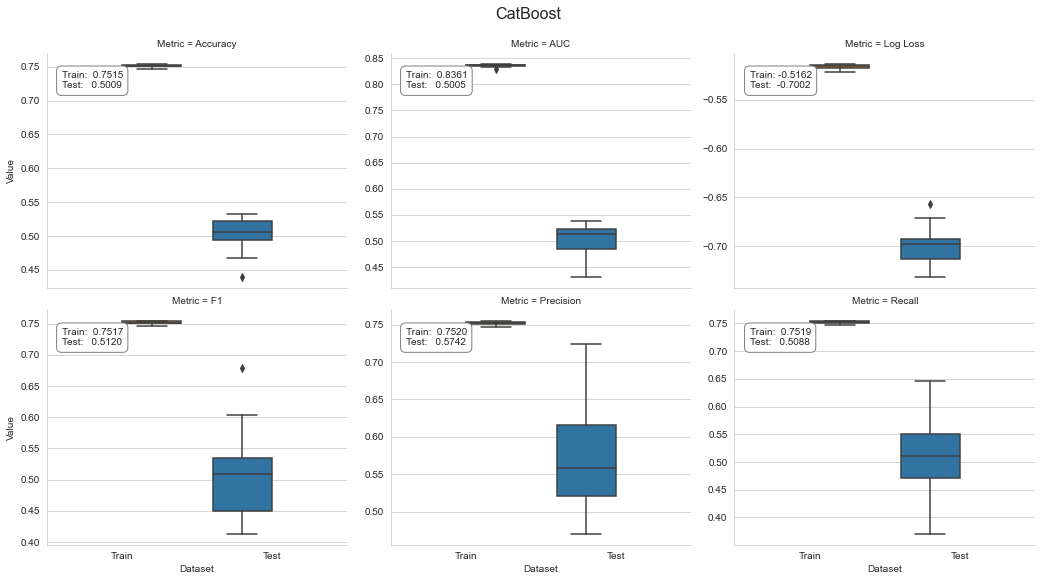

In [75]:
plot_result(cat_gpu_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

## Compare Results

In [76]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           'Gradient Booster': gb_result,
           'XGBoost': xbg_result,
           'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result,
           'CatBoost GPU': cat_gpu_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
LightGBM Factors,0.526646,0.507874,0.447819,-0.704354,0.563207,0.493625
Gradient Booster,0.518694,0.499760,0.330737,-0.726302,0.543314,0.431390
Random Forest,0.515390,0.500695,0.437020,-0.723907,0.560962,0.456740
CatBoost,0.514510,0.501443,0.502954,-0.697303,0.571752,0.534912
AdaBoost,0.512397,0.496719,0.376783,-0.693310,0.537264,0.459320
XGBoost,0.506702,0.493143,0.324929,-0.717270,0.532639,0.436096
Baseline,0.504968,0.504968,0.523382,-17.138543,0.577828,0.503795
CatBoost GPU,0.500534,0.500918,0.512007,-0.700151,0.574199,0.508804
LightGBM Dummies,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
algo_dict = dict(zip(['dummy_clf', 'random_forest', 'adaboost', 'sklearn_gbm', 
                      'xgboost', 'lgb_factors', 'lgb_dummies', 'catboost', 'catboost_gpu'],
                     ['Baseline', 'Random Forest', 'AdaBoost', 'Gradient Booster', 
                      'XGBoost', 'LightGBM Dummies', 'LightGBM Factors', 'CatBoost', 'CatBoost GPU']))

In [78]:
print(run_time)

{'lgb_factors': 45.11120891571045, 'lgb_dummies': 3.2166881561279297, 'catboost': 796.2180466651917, 'catboost_gpu': 339.5099403858185}


In [79]:
r = pd.Series(run_time).to_frame('t')
r.index = r.index.to_series().map(algo_dict)
r.to_csv(results_path / 'runtime.csv')

In [80]:
# r = pd.read_csv(results_path / 'runtime.csv', index_col=0)

In [81]:
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
auc = auc[auc.Model != 'Baseline']

KeyError: "['Baseline'] not found in axis"

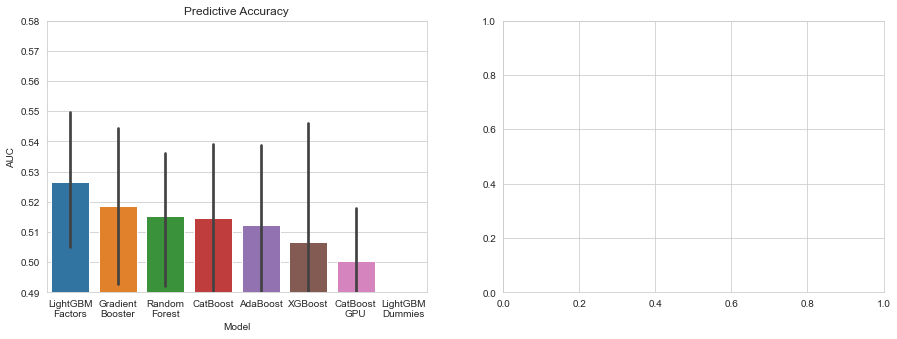

In [82]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
idx = df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index
sns.barplot(x='Model', y='AUC',
            data=auc,
            order=idx, ax=axes[0])
axes[0].set_xticklabels([c.replace(' ', '\n') for c in idx])
axes[0].set_ylim(.49, .58)
axes[0].set_title('Predictive Accuracy')

(r.drop('Baseline').sort_values('t').rename(index=lambda x: x.replace(' ', '\n'))
 .plot.barh(title='Runtime', ax=axes[1], logx=True, legend=False))
axes[1].set_xlabel('Seconds (log scale)')
sns.despine()
fig.tight_layout()